
Time step 210: curvature thresholds from n=9060 samples
  q1 (at 0.100)  = -1.538556e-01
  q2 (at 0.900) = 1.883563e-01


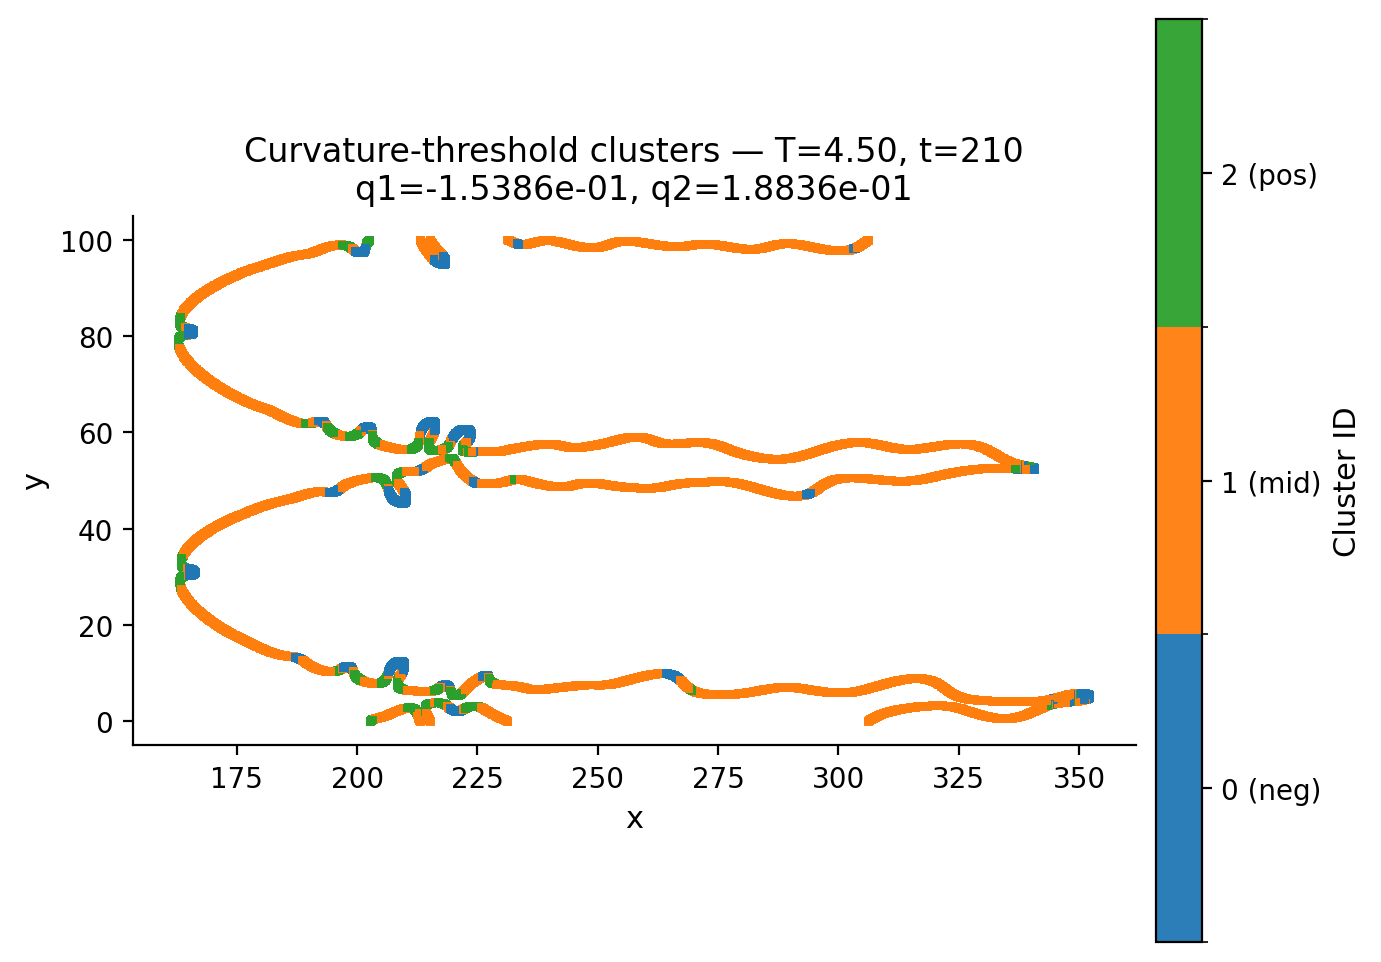

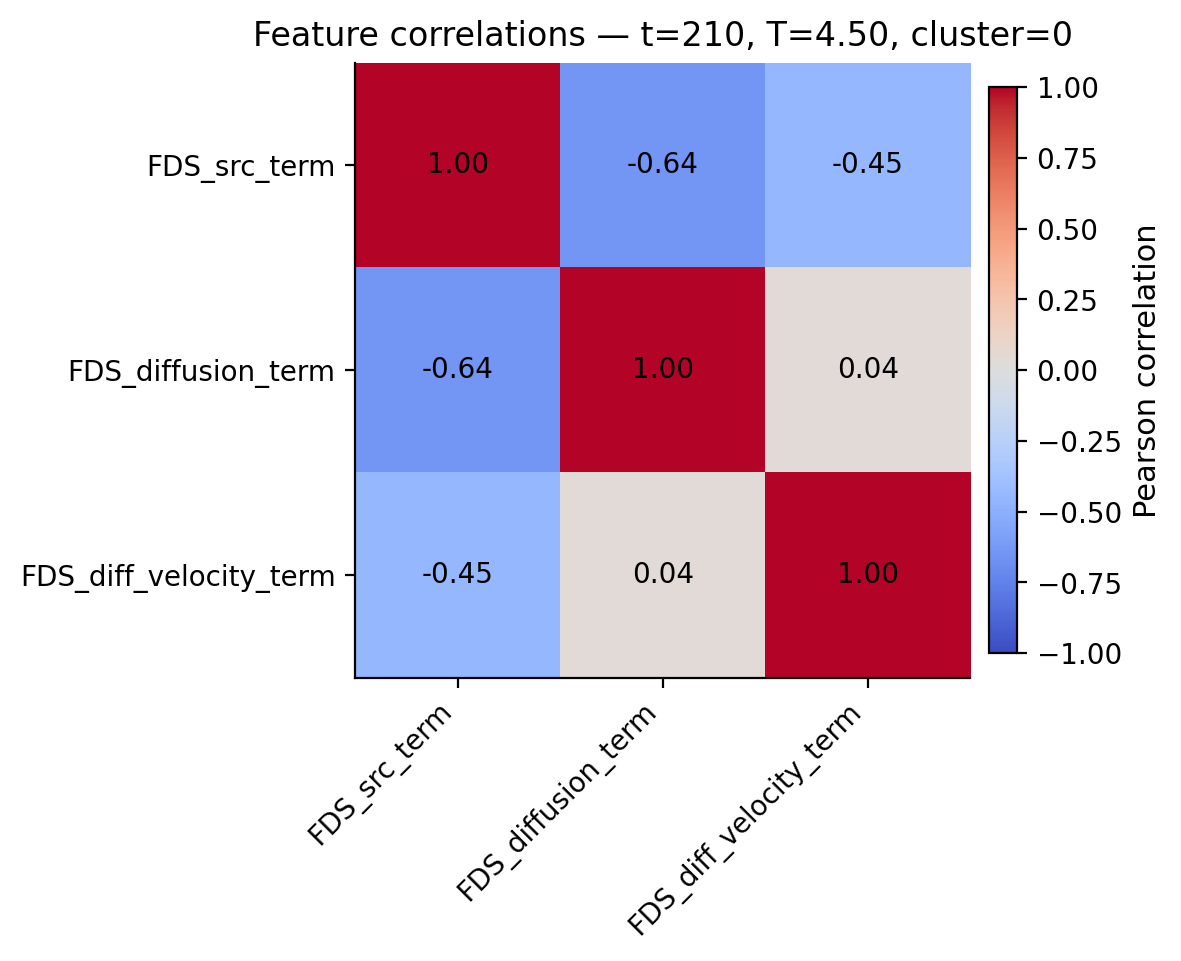

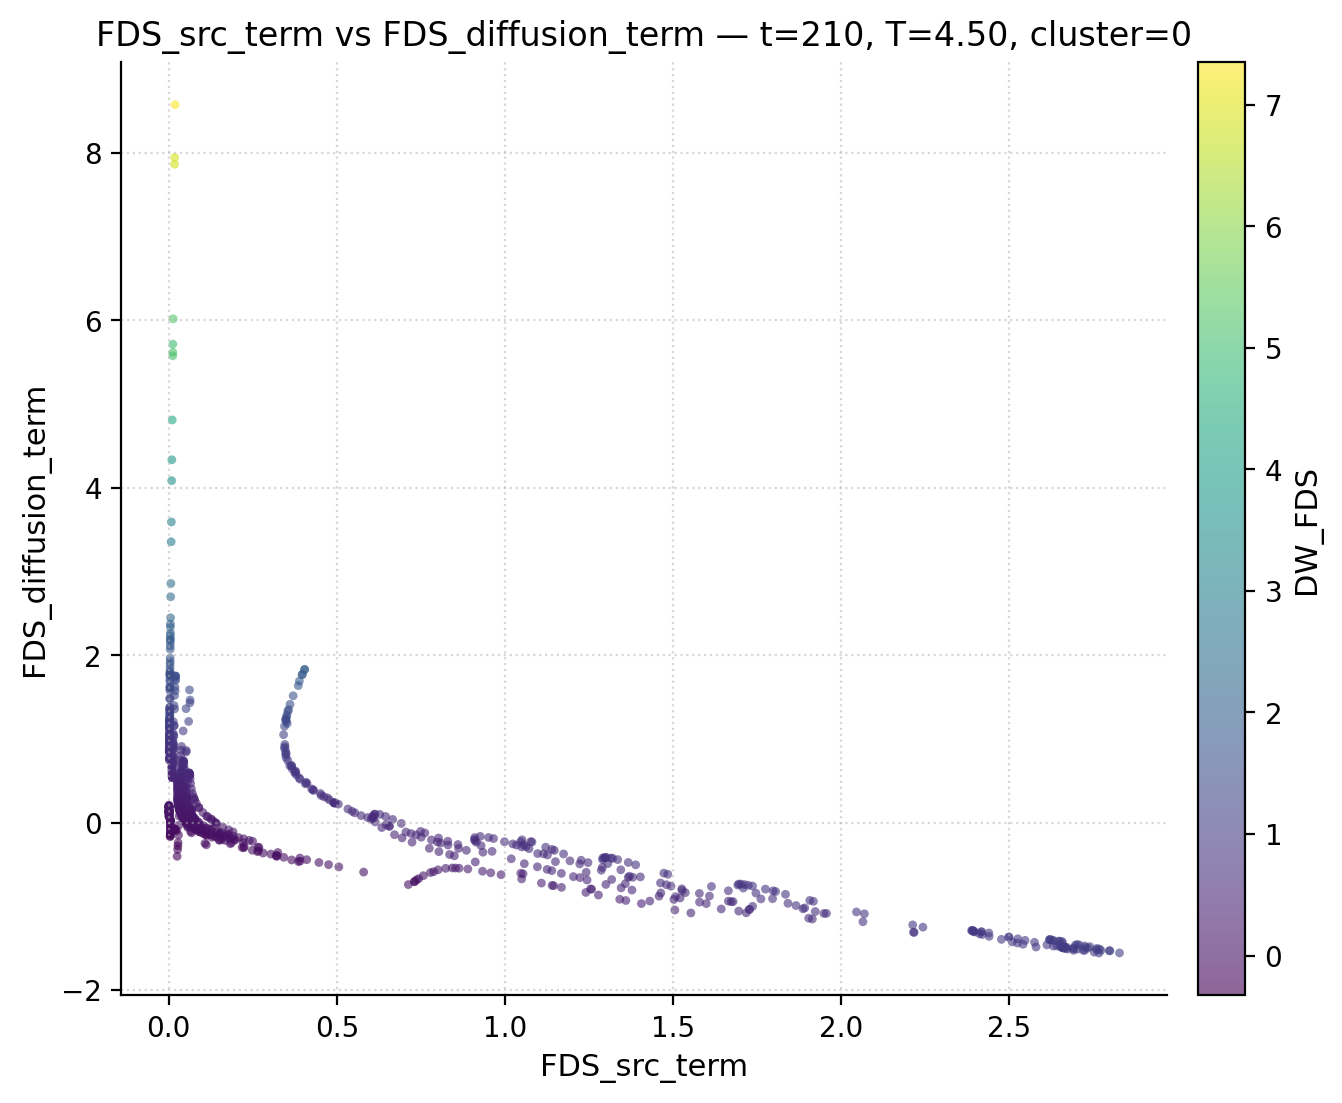

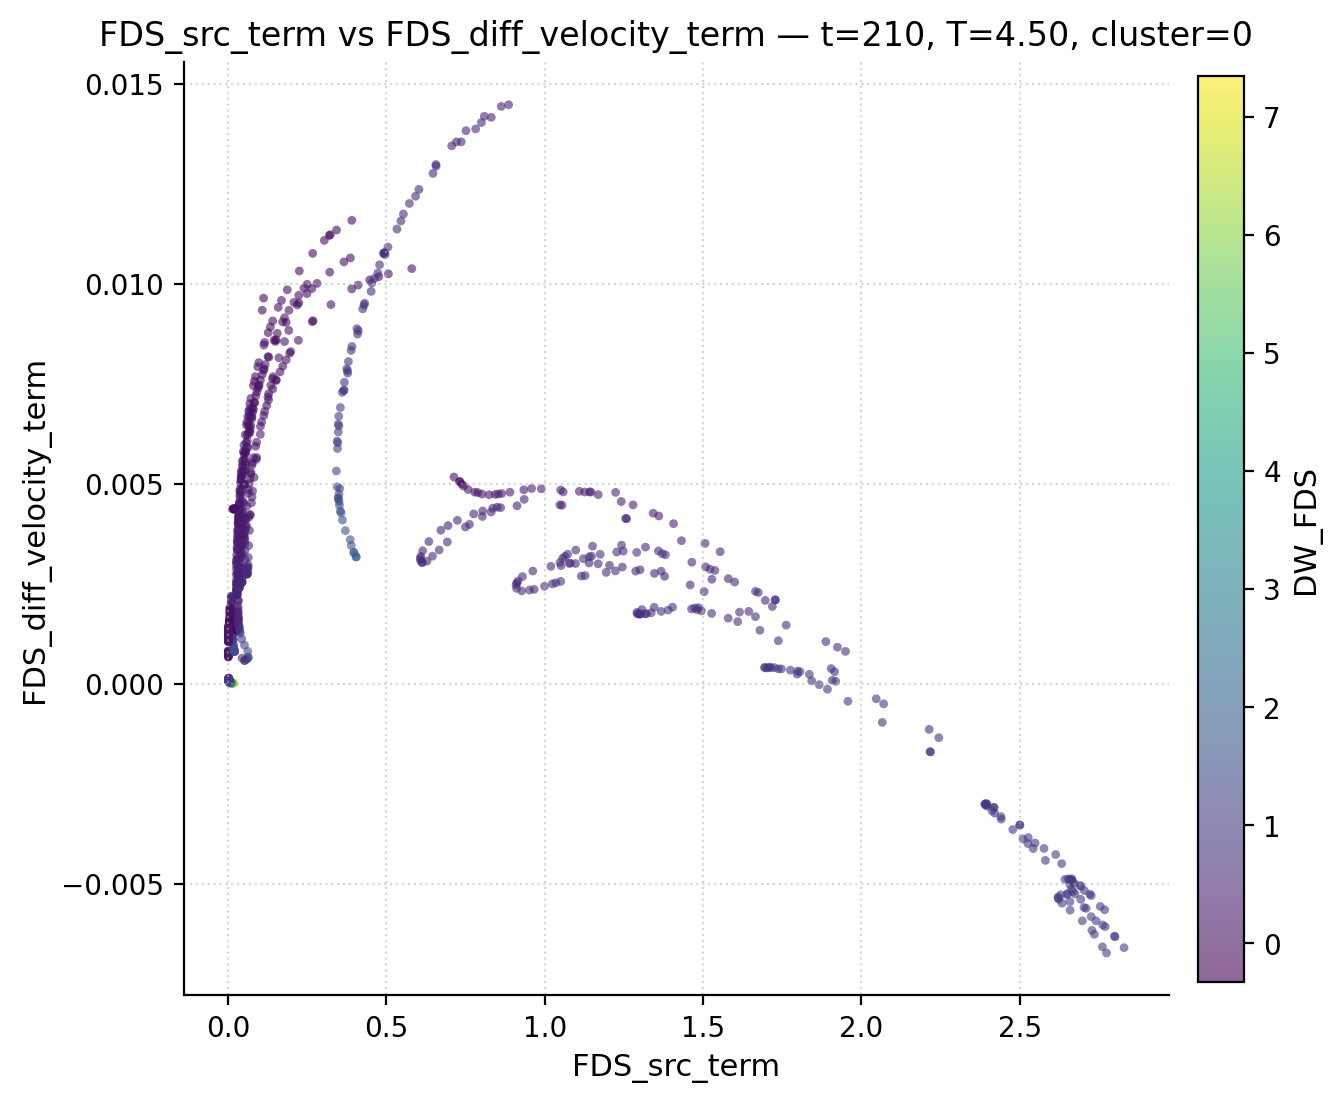

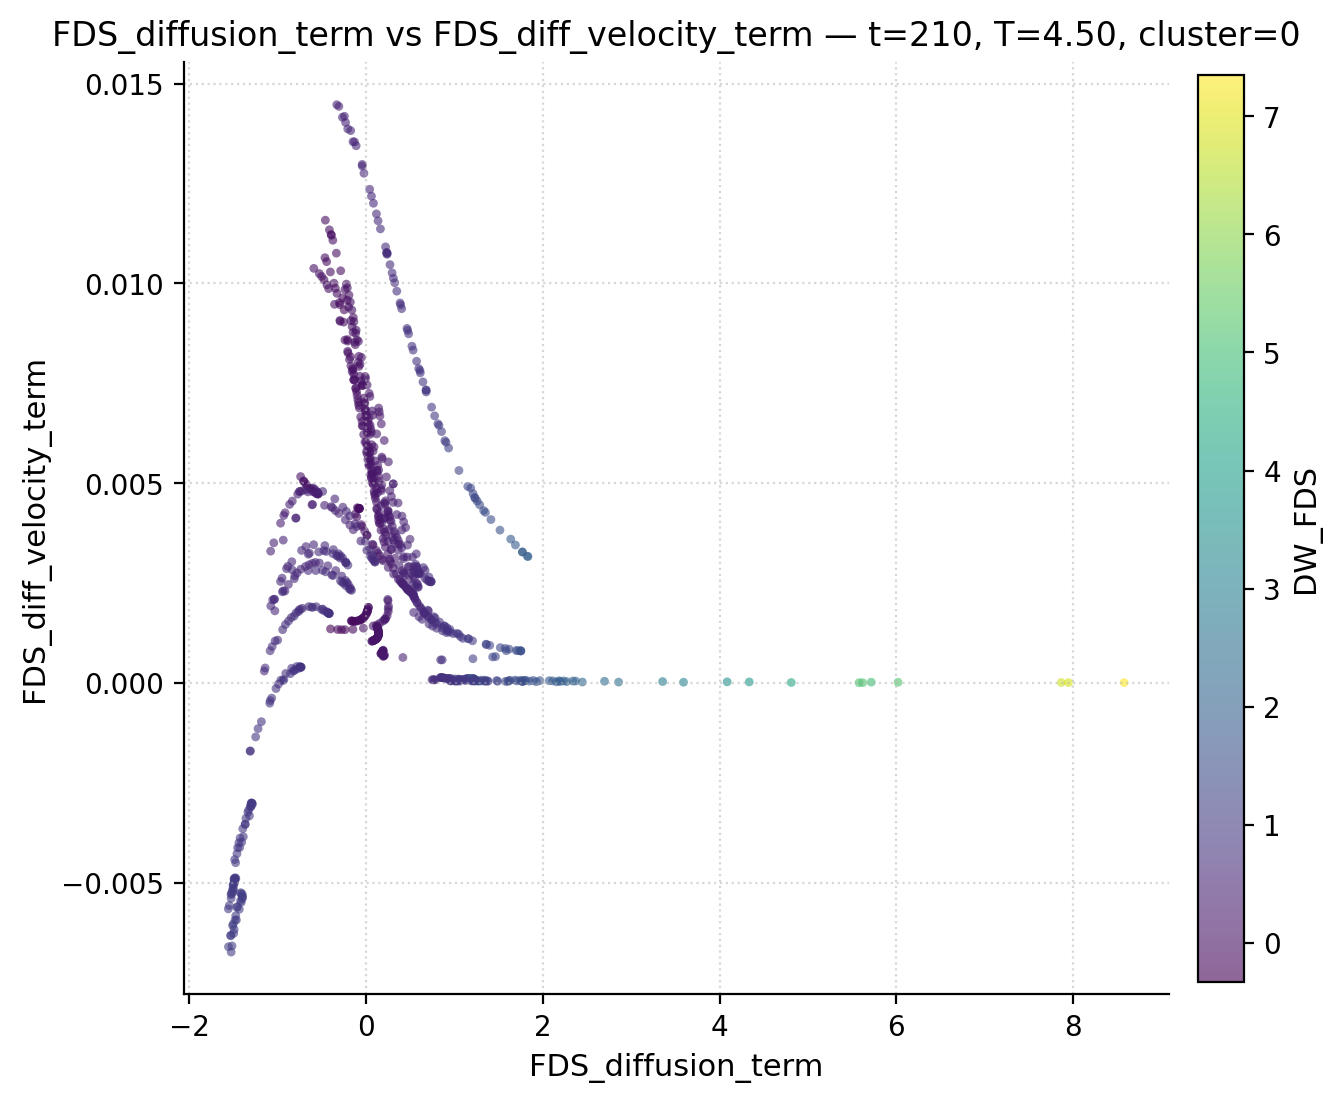

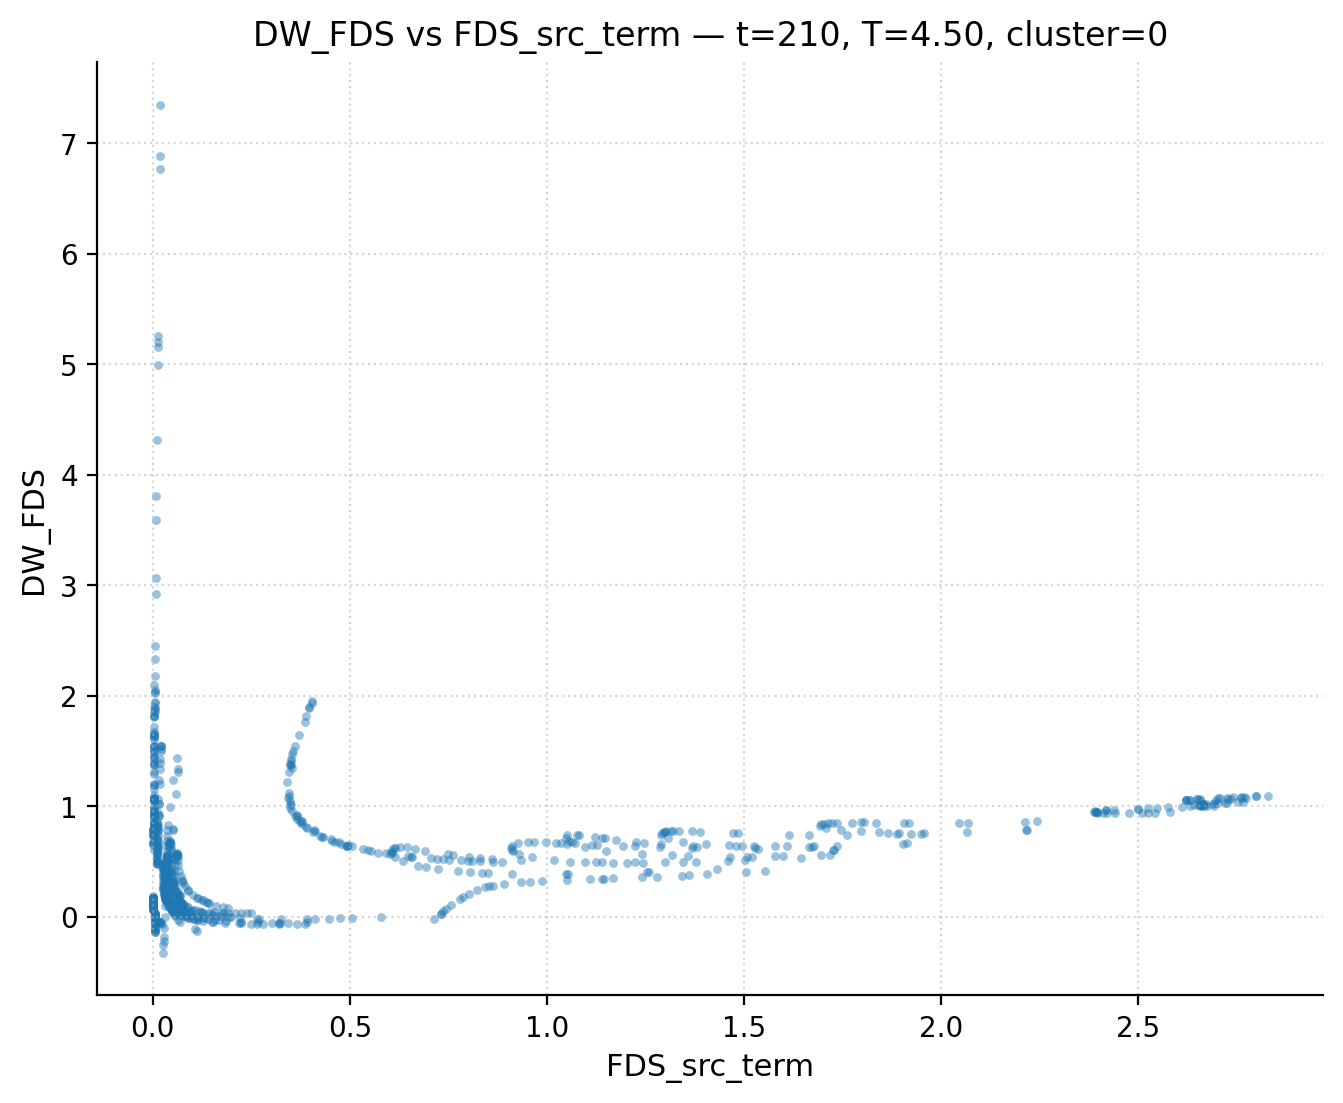

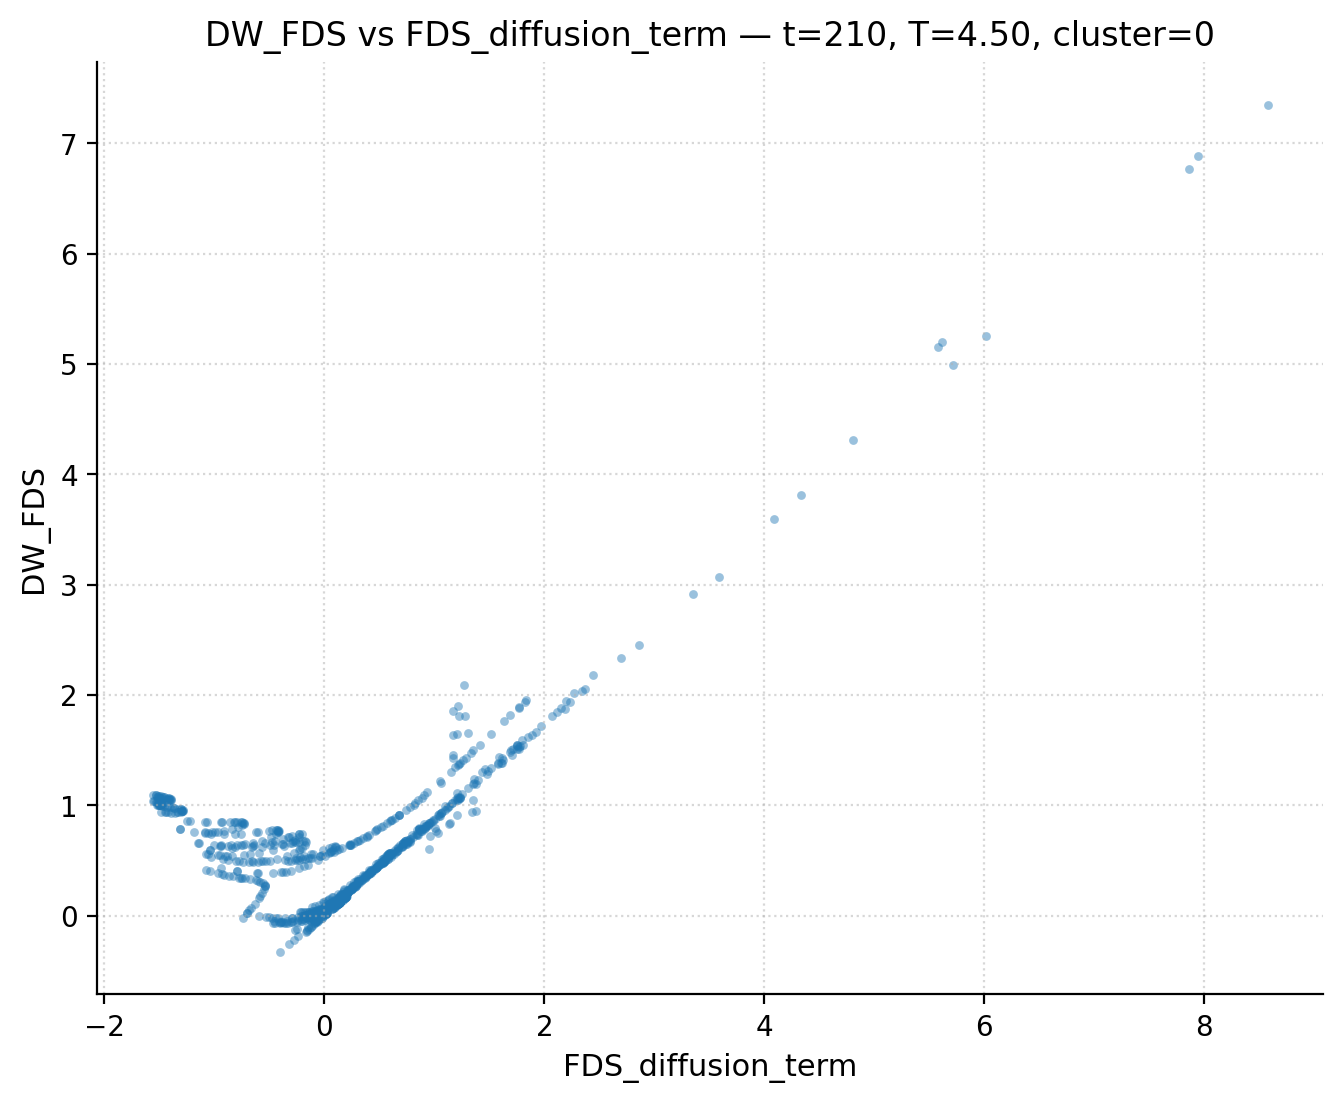

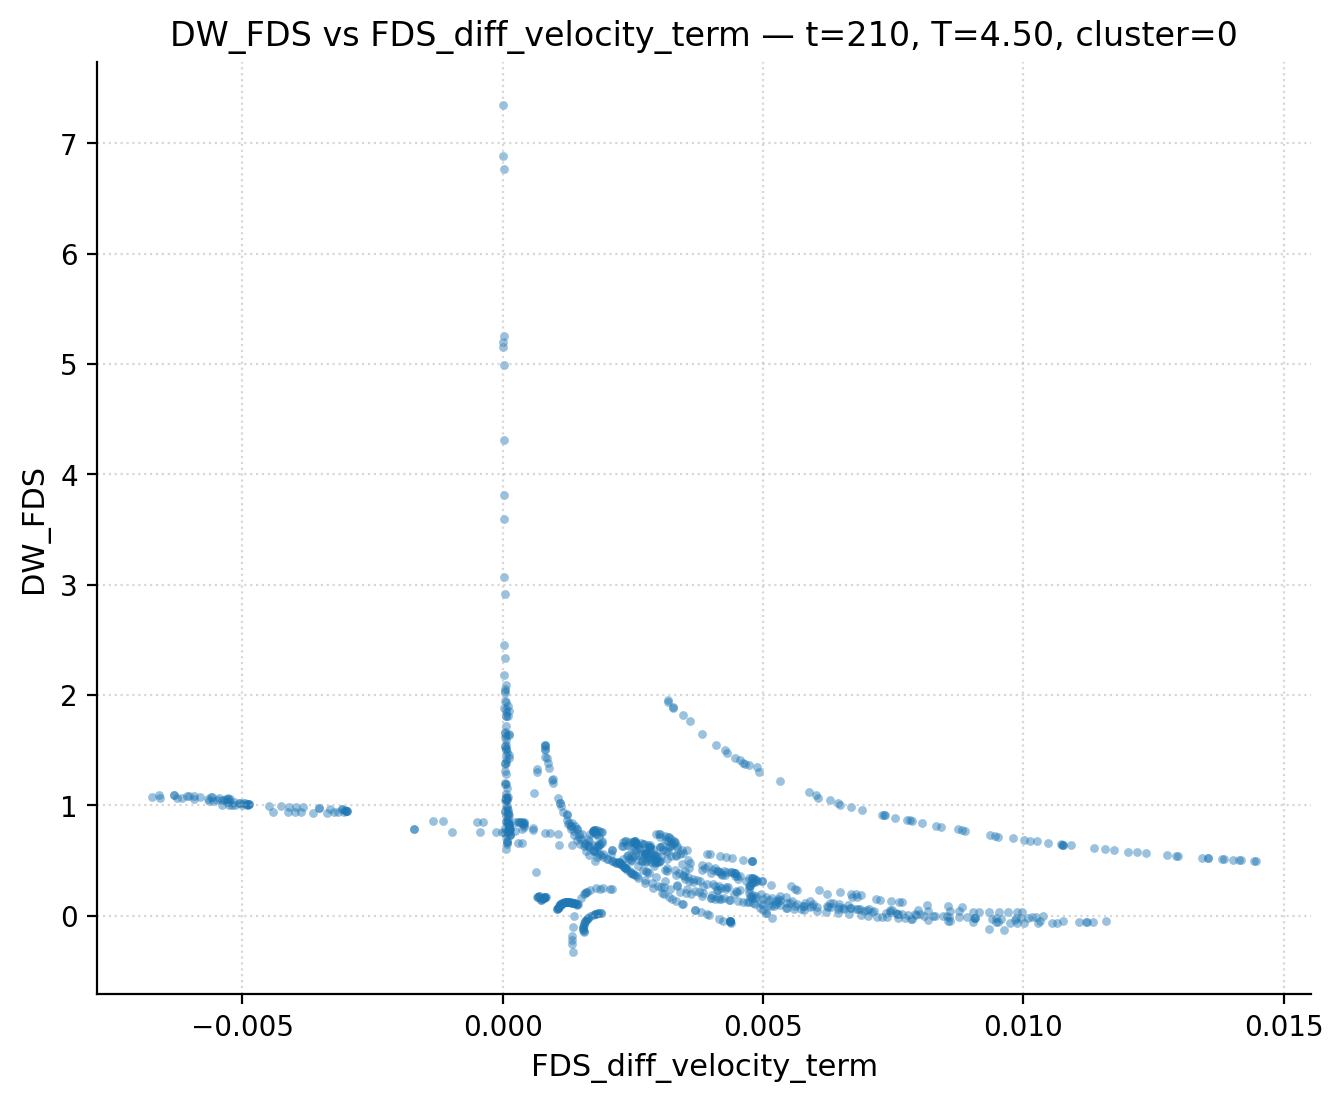

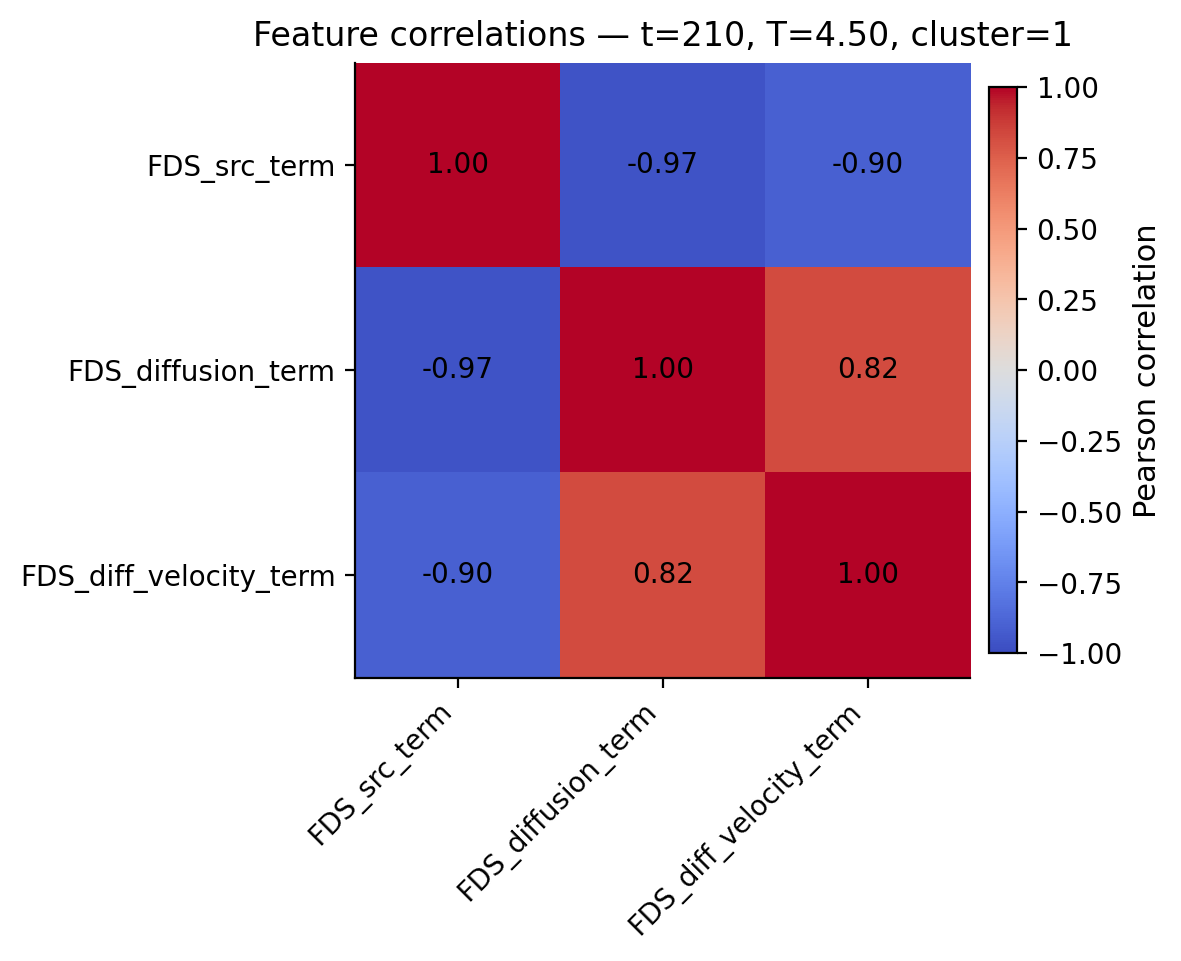

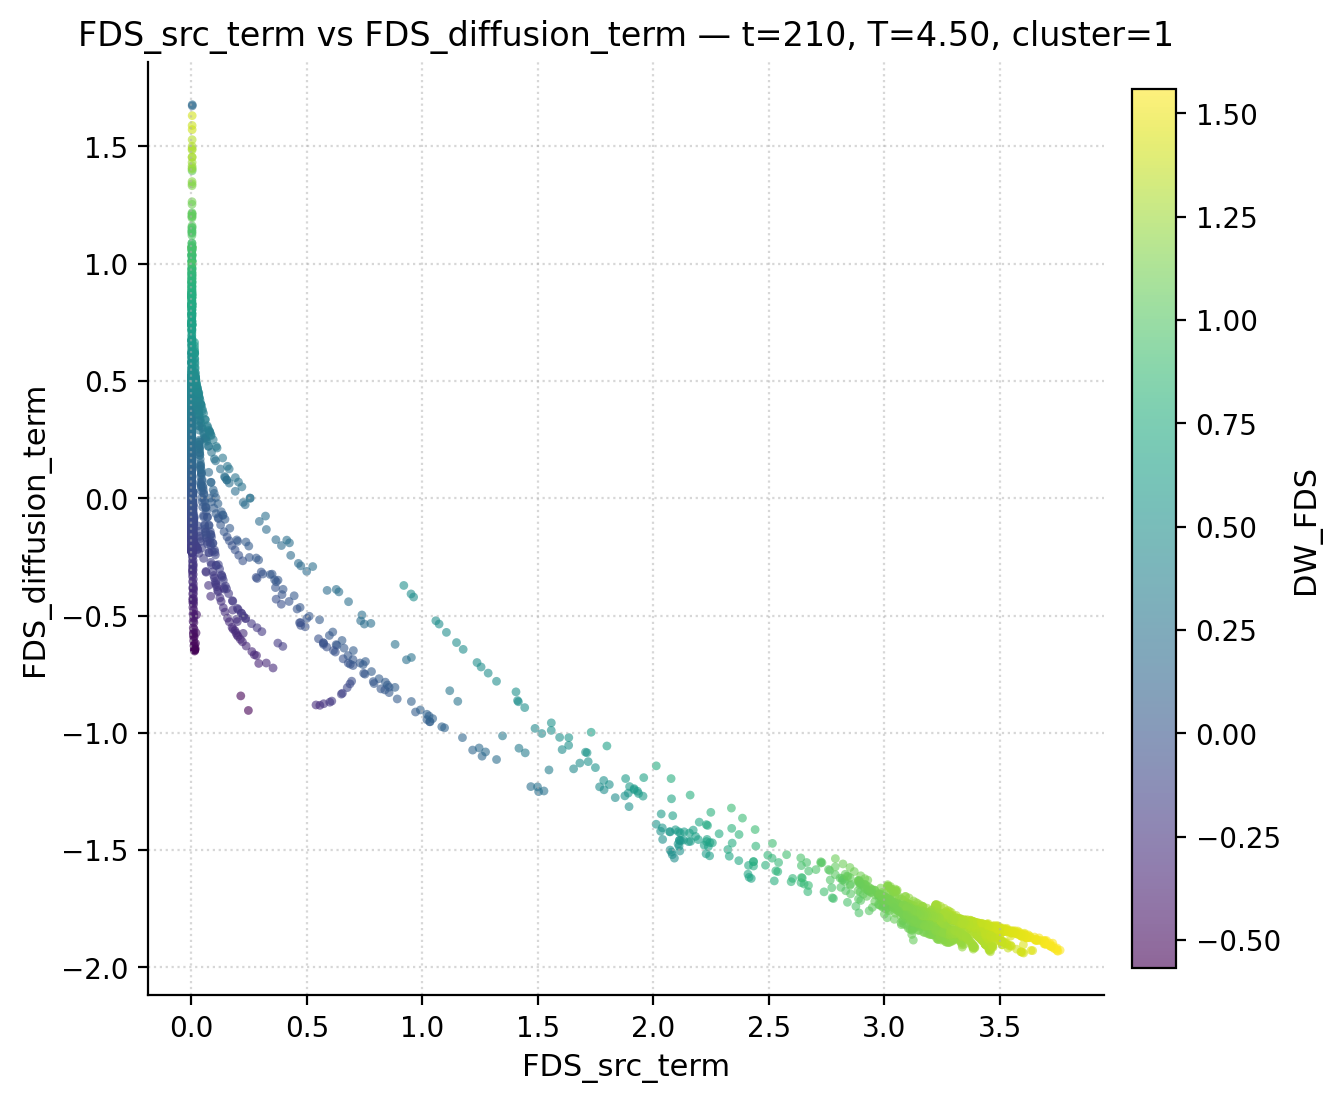

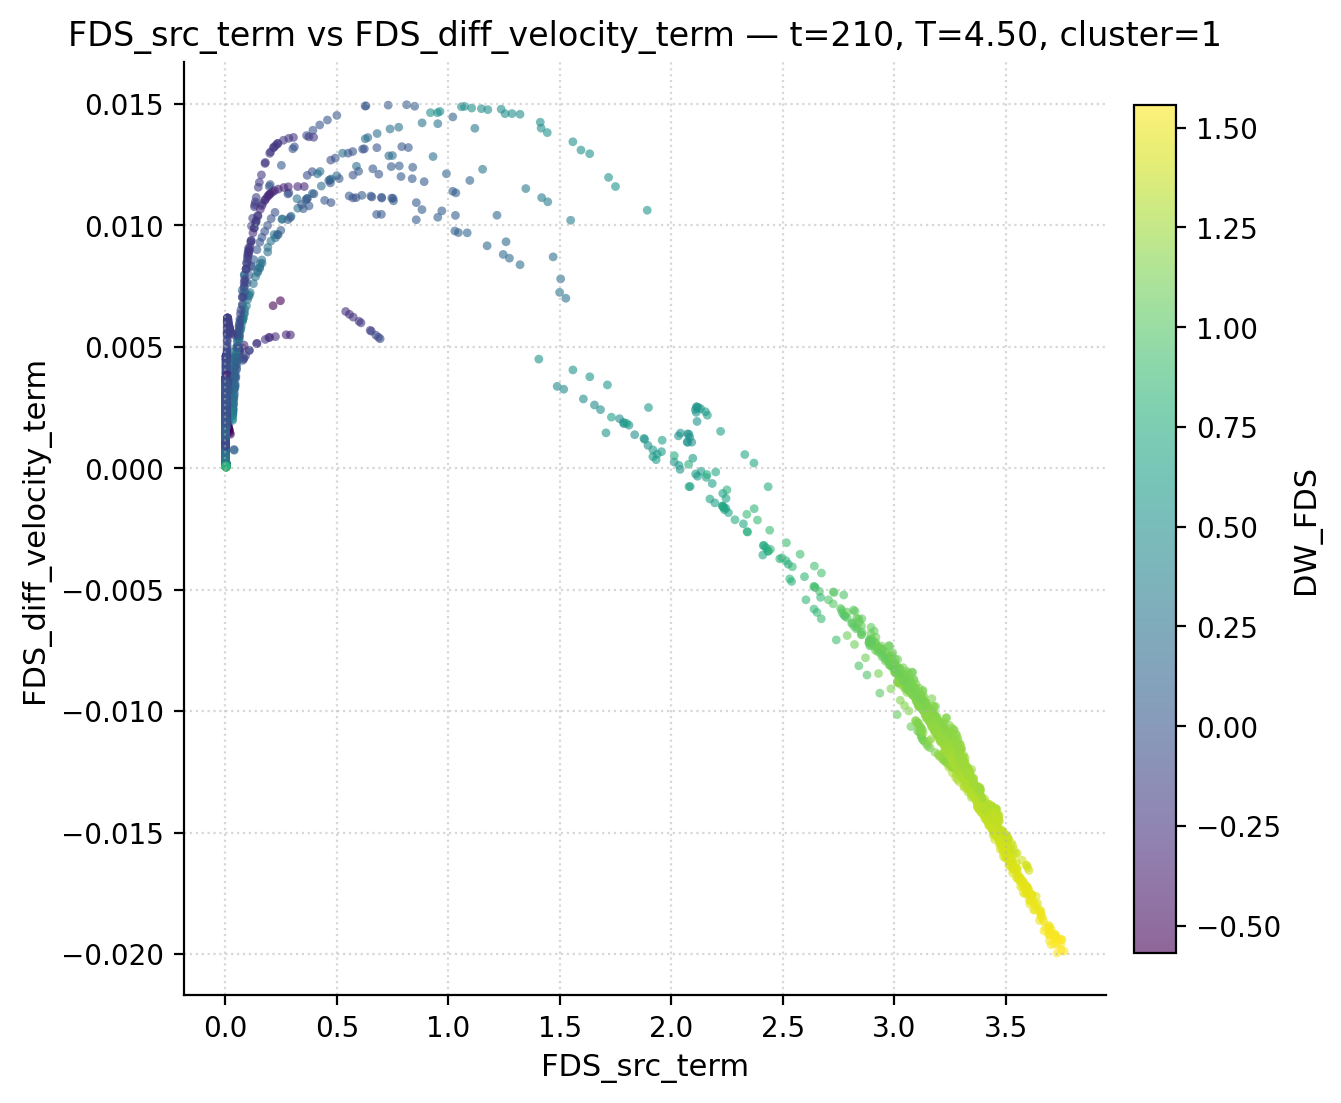

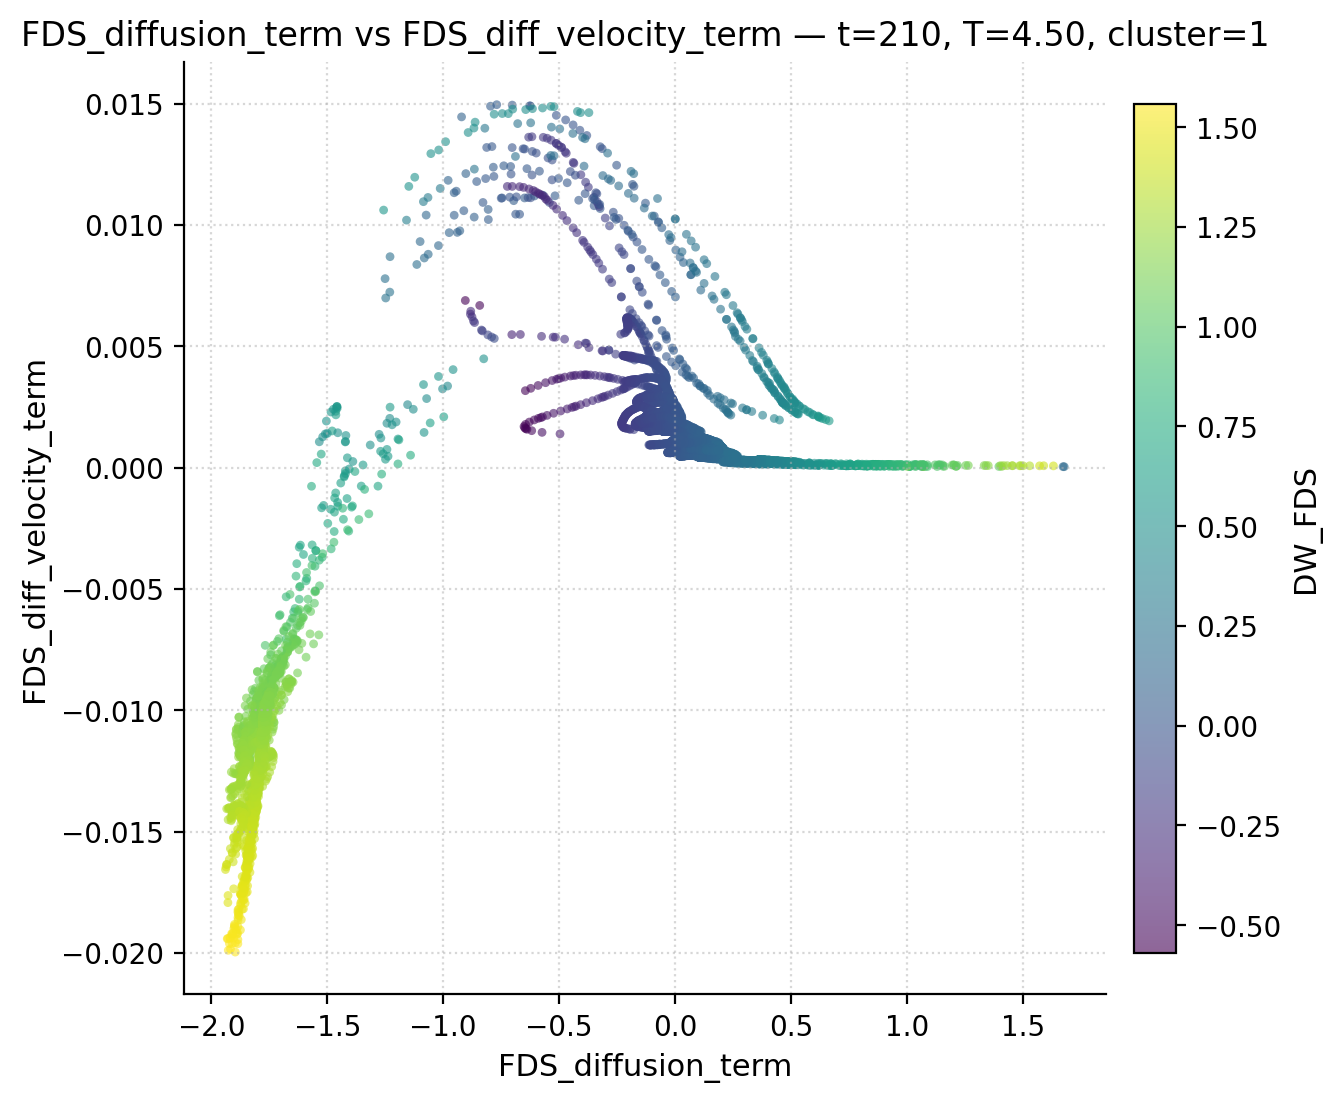

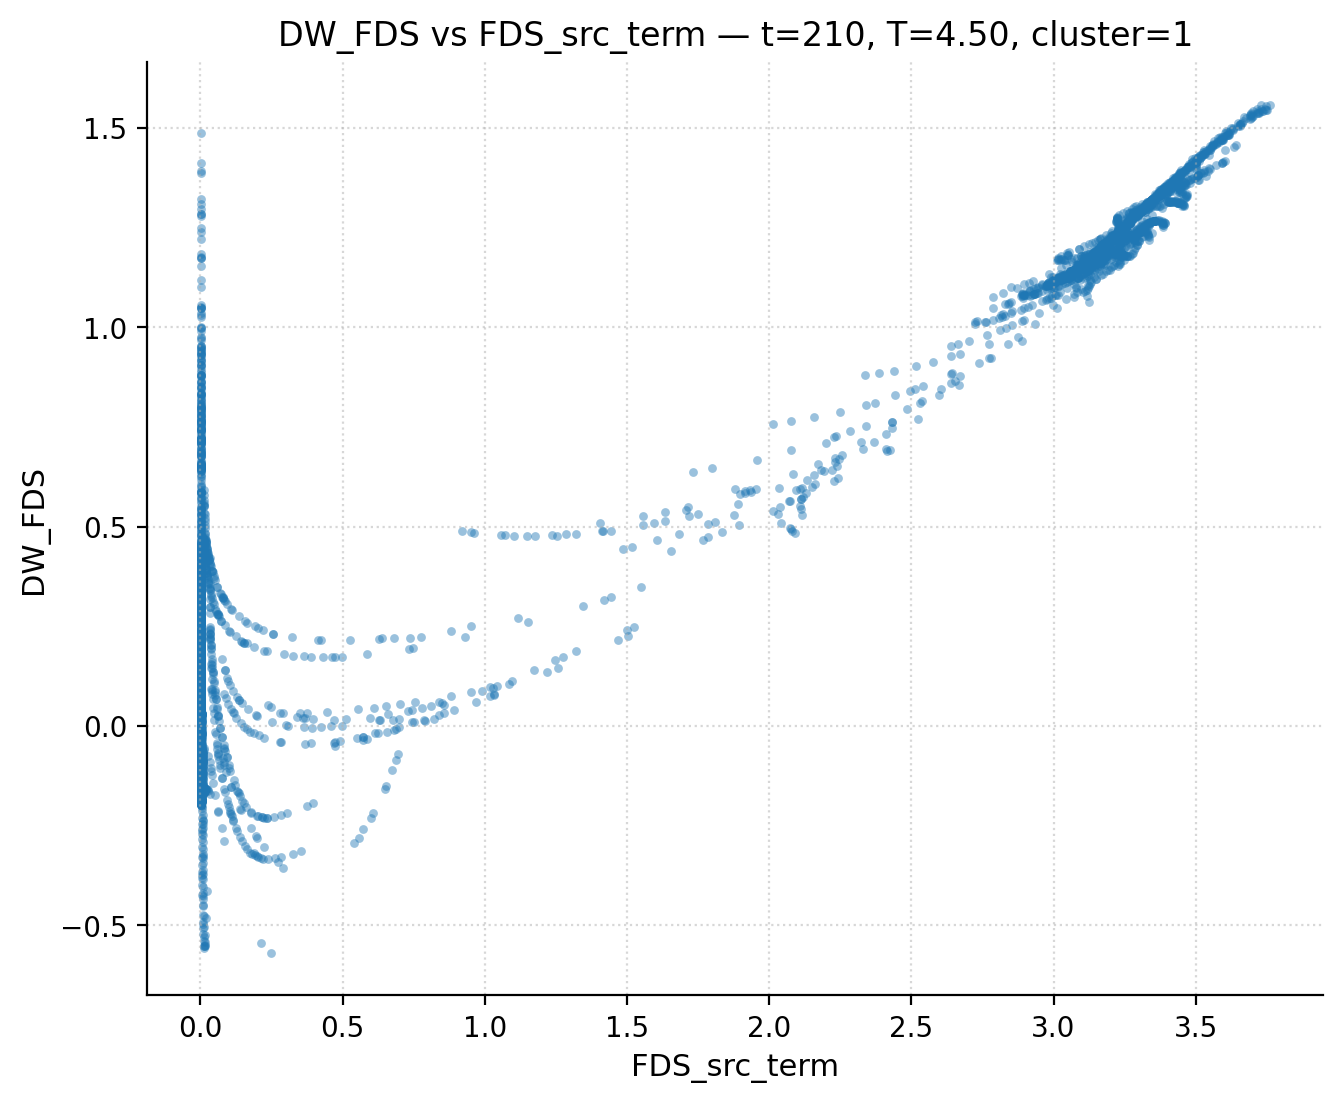

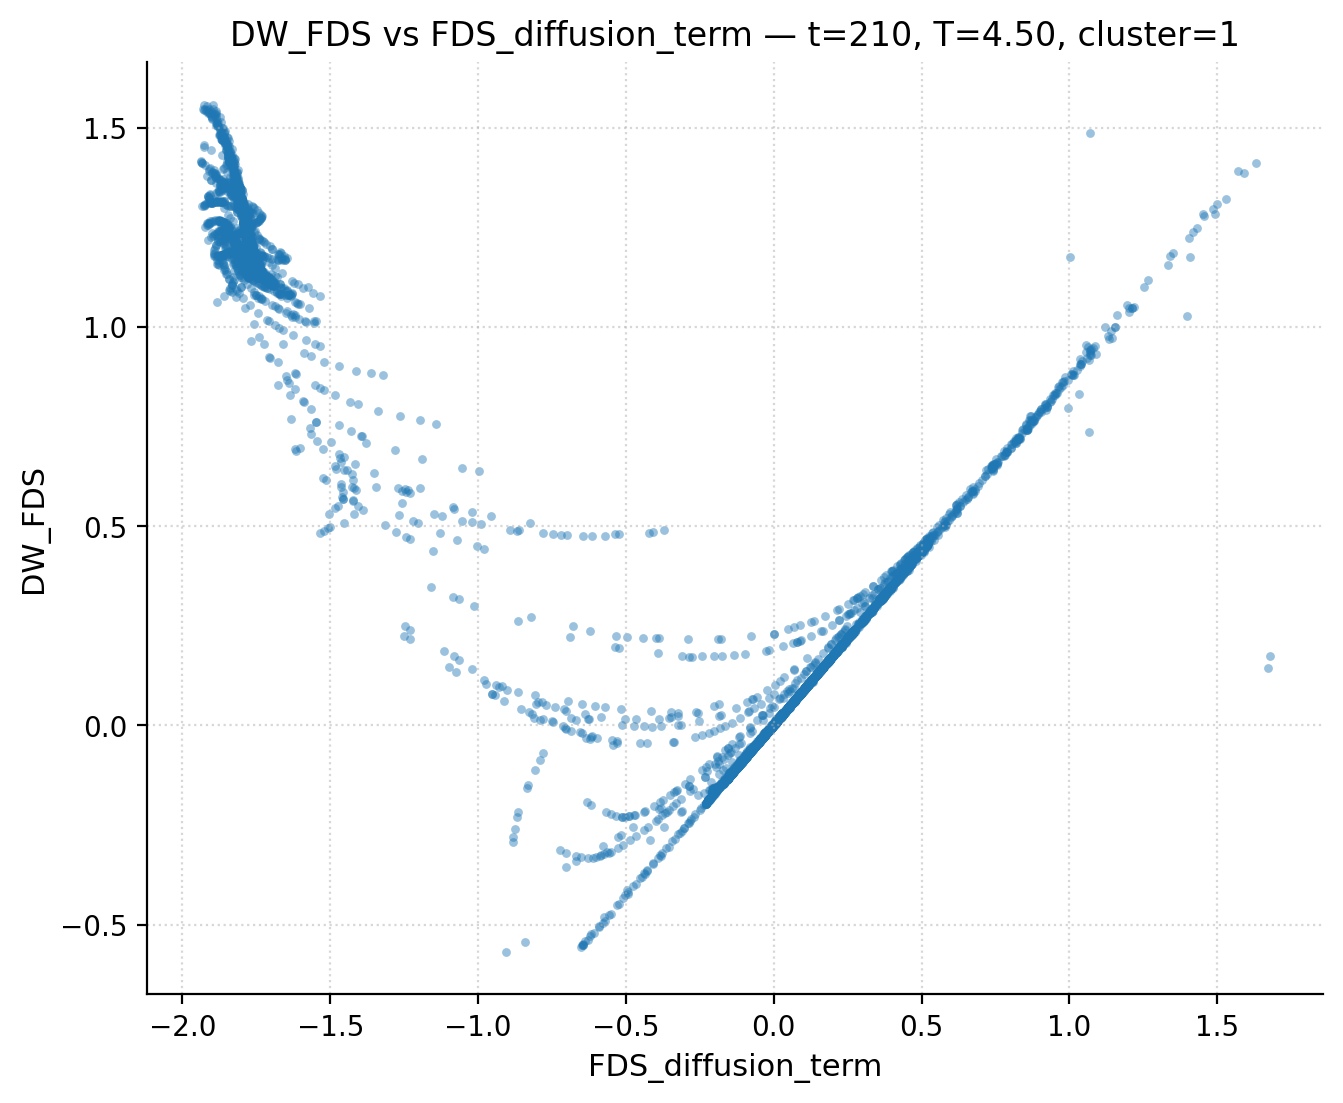

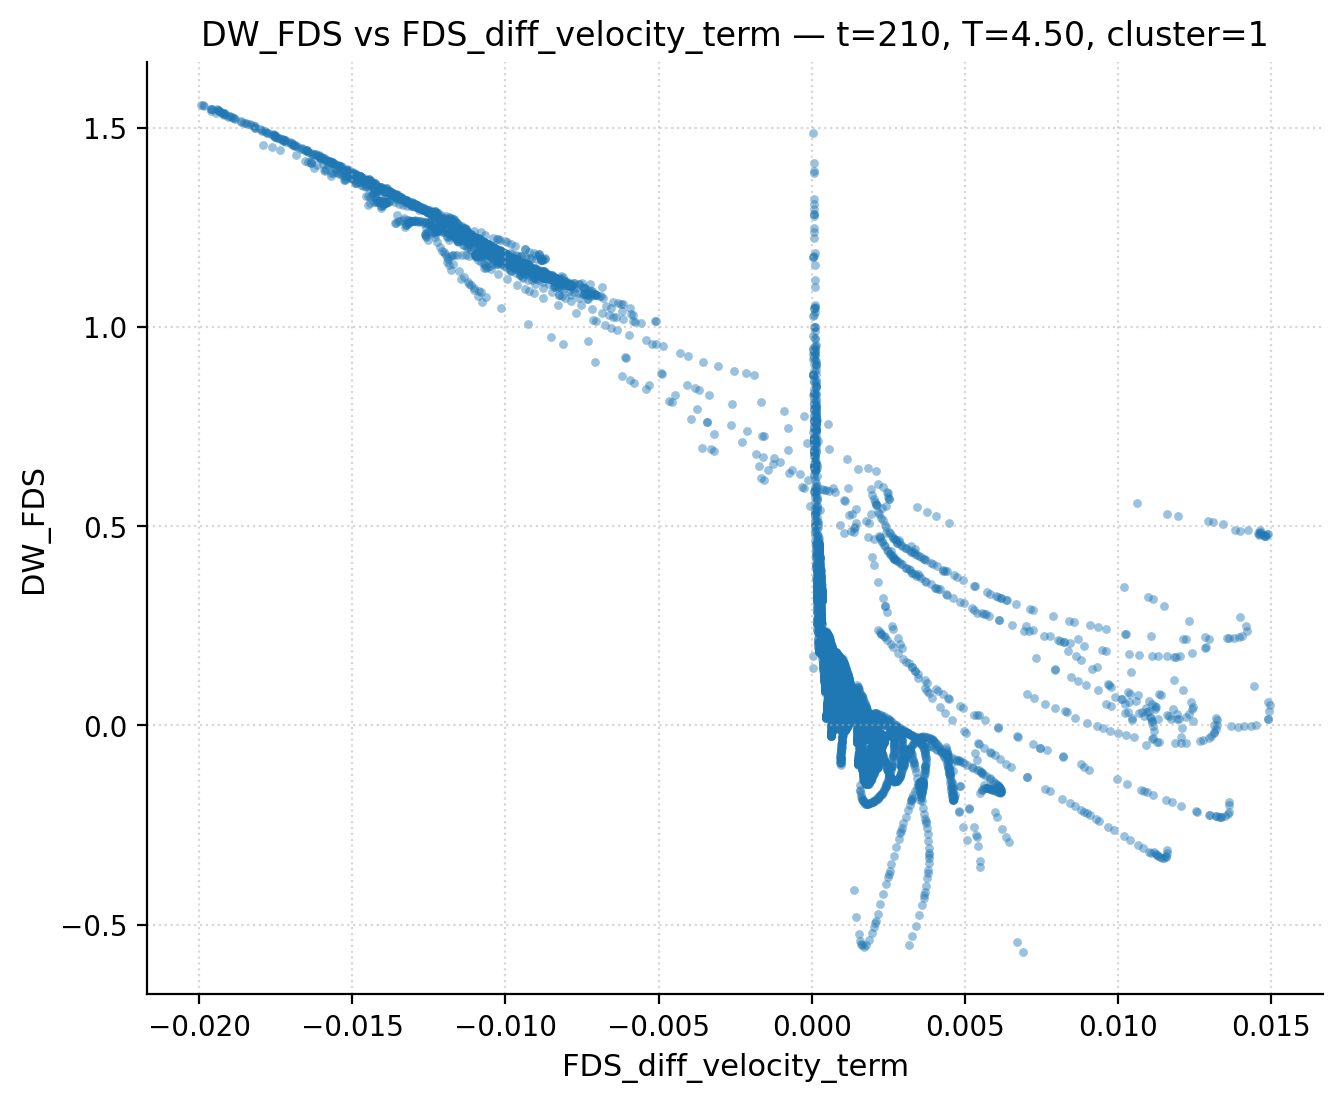

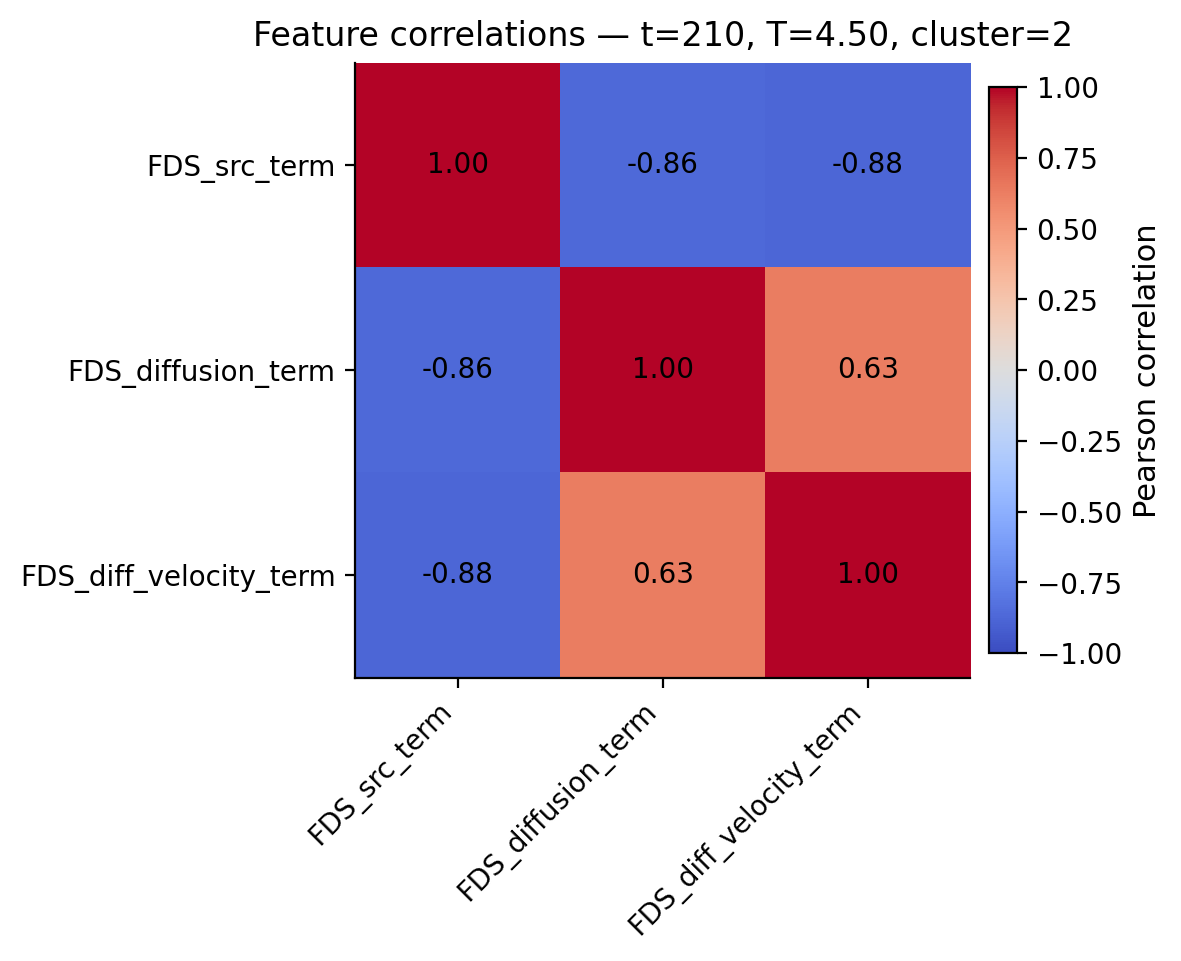

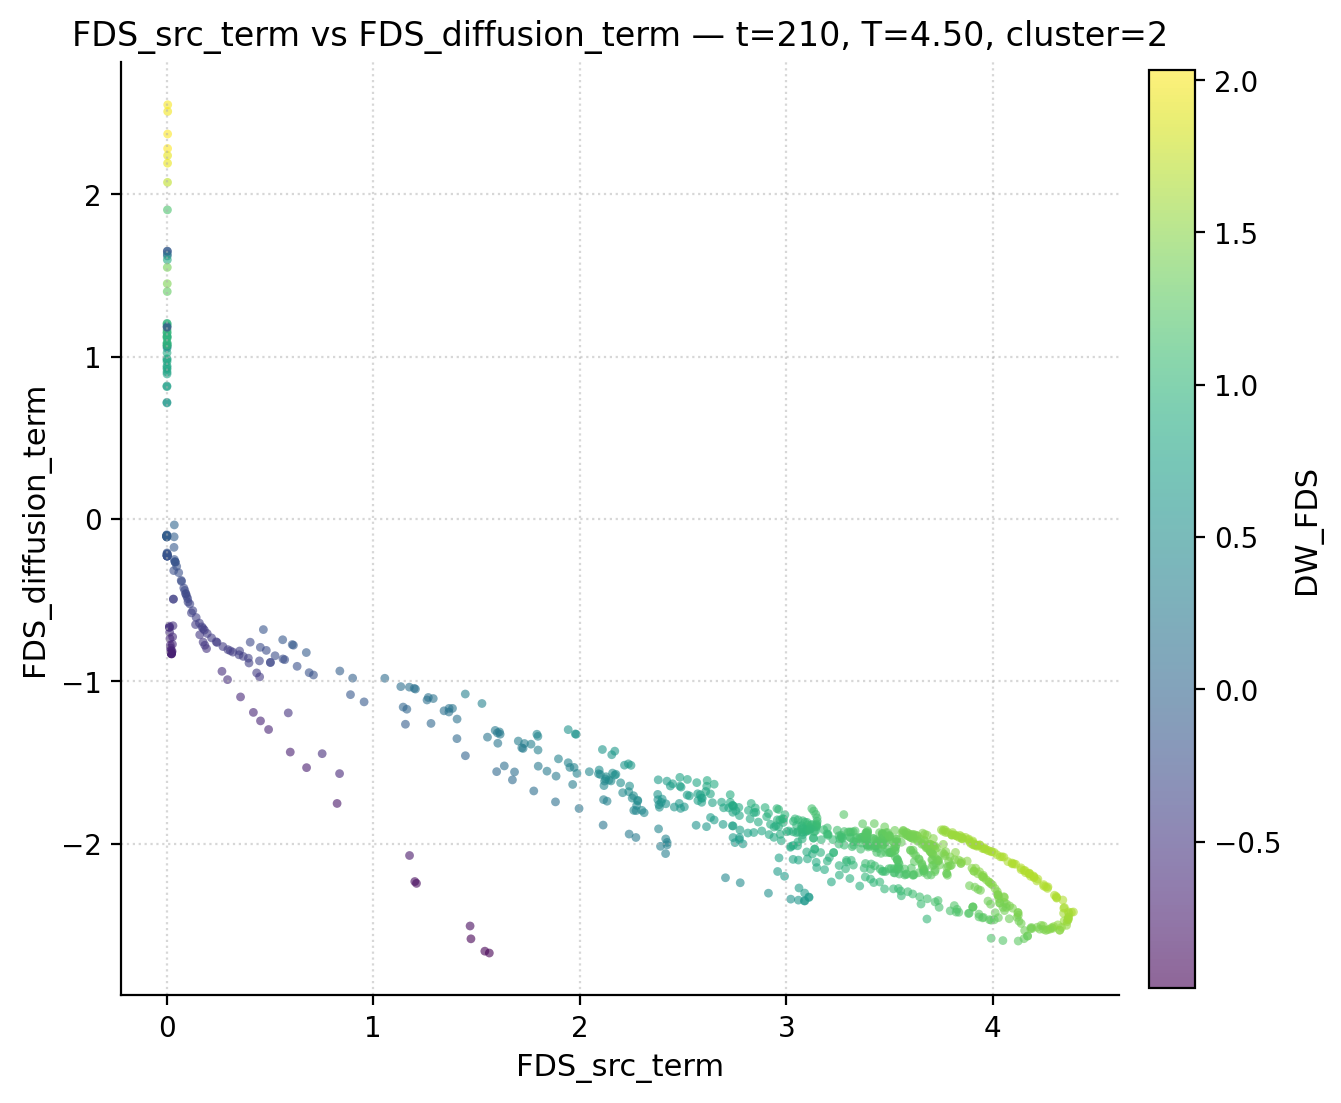

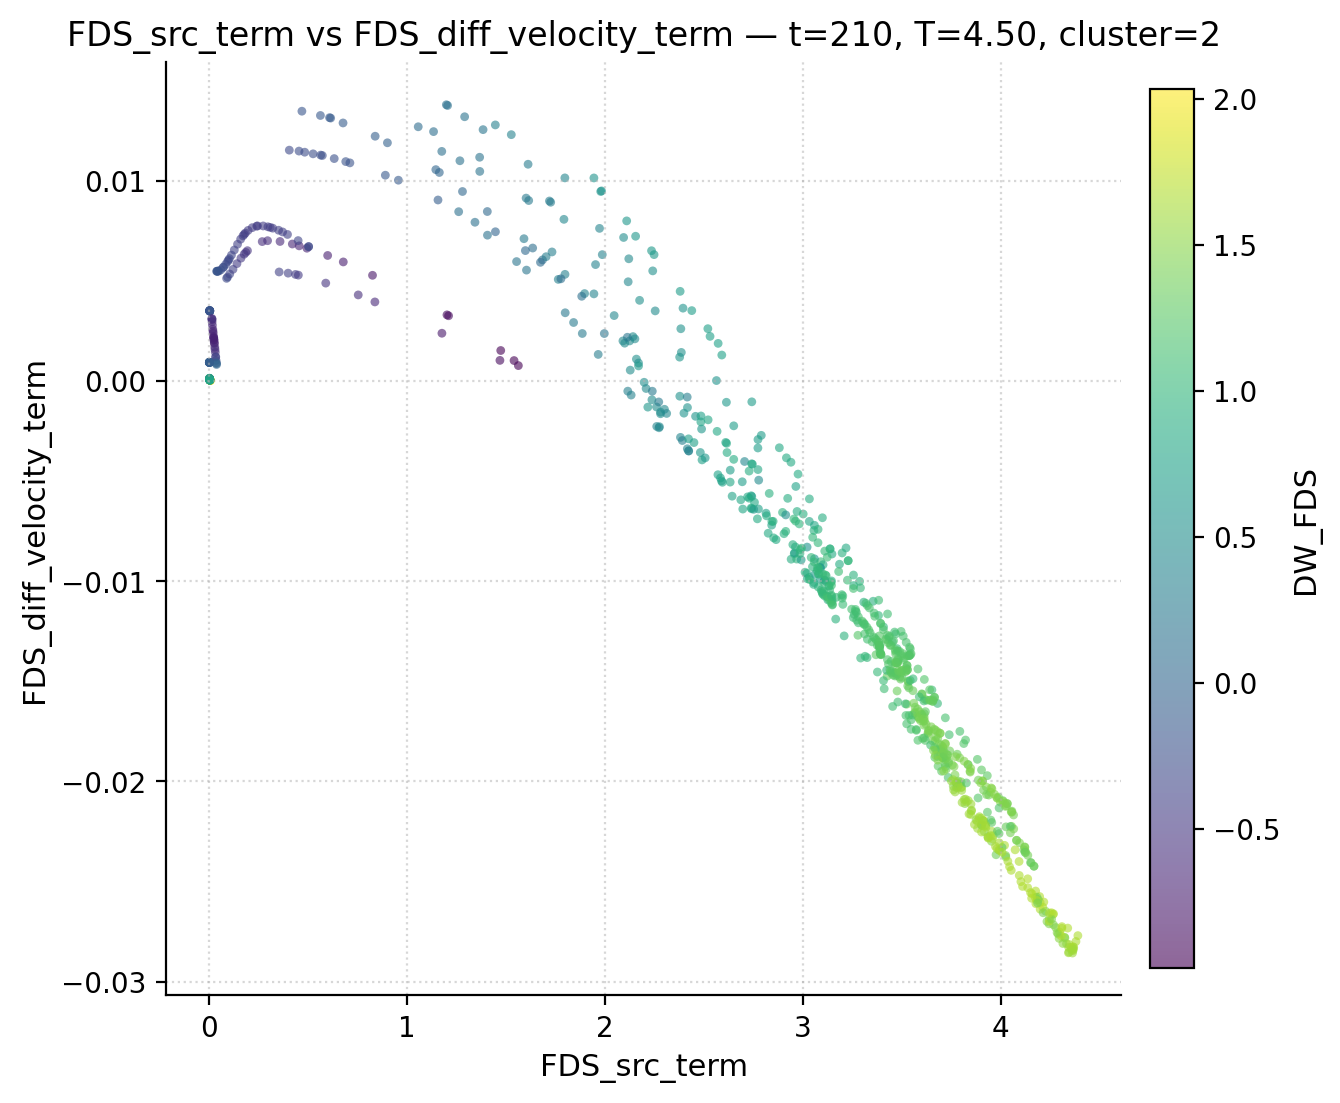

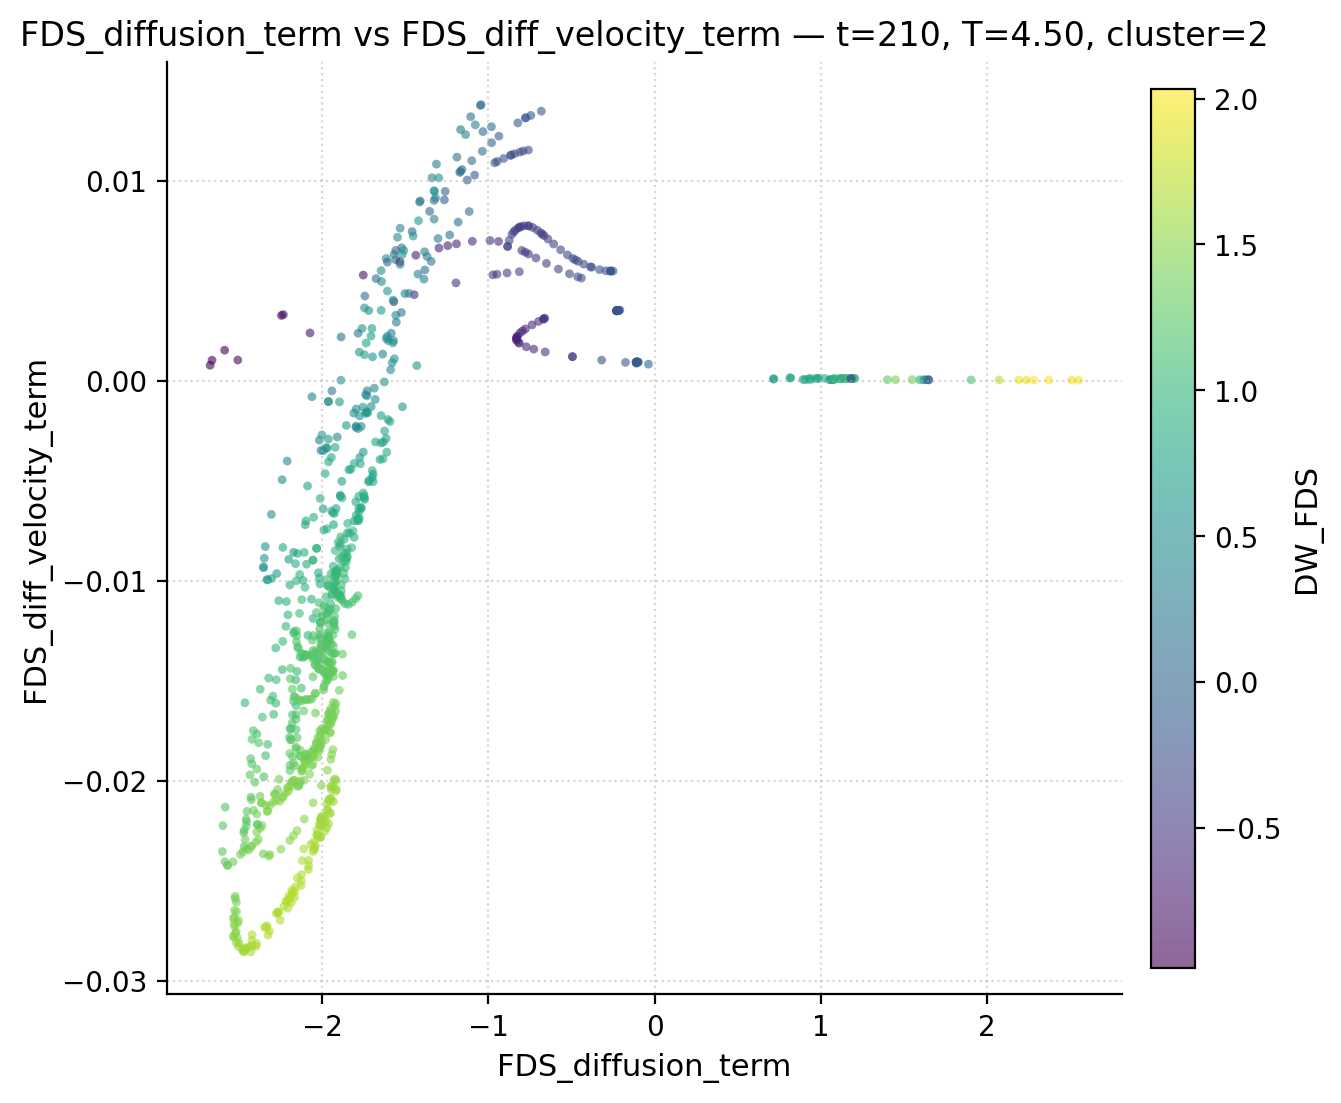

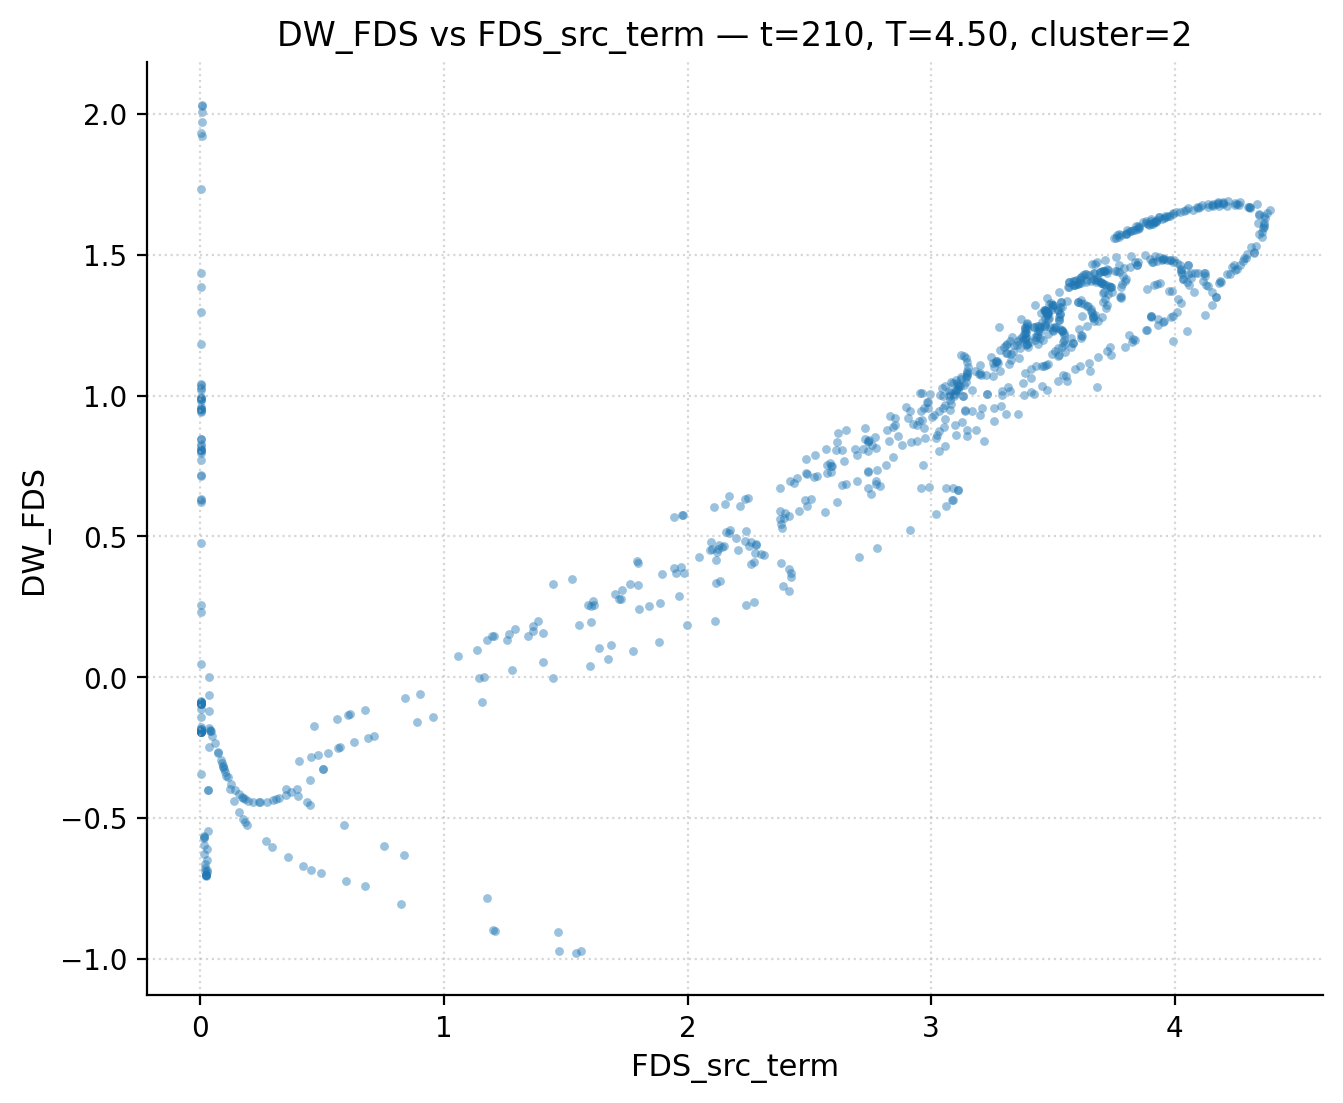

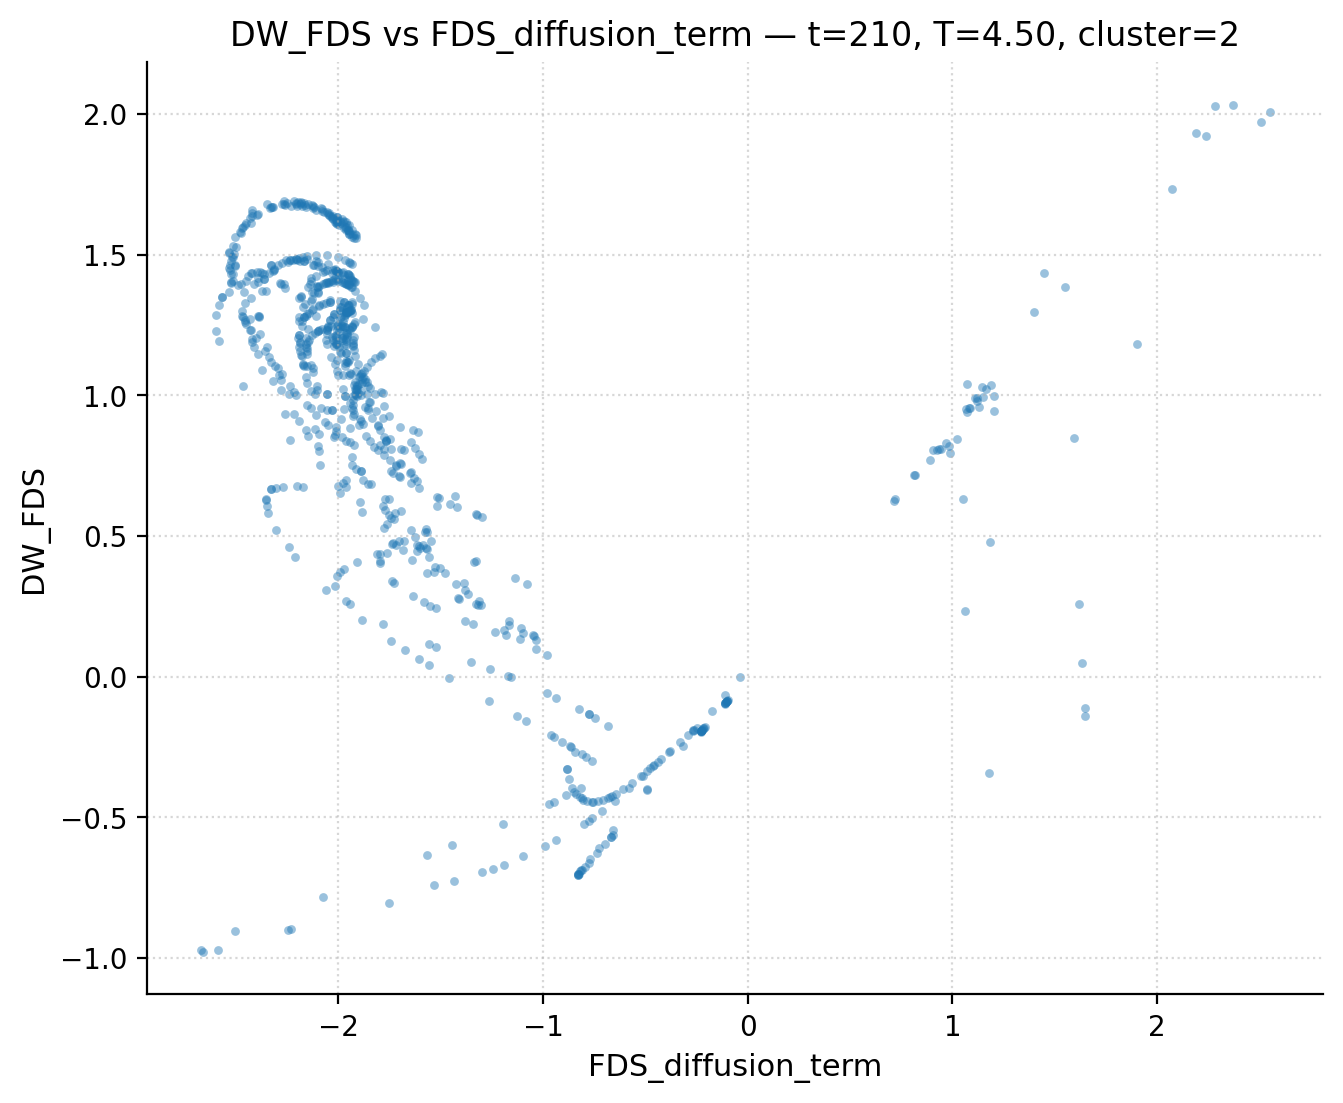

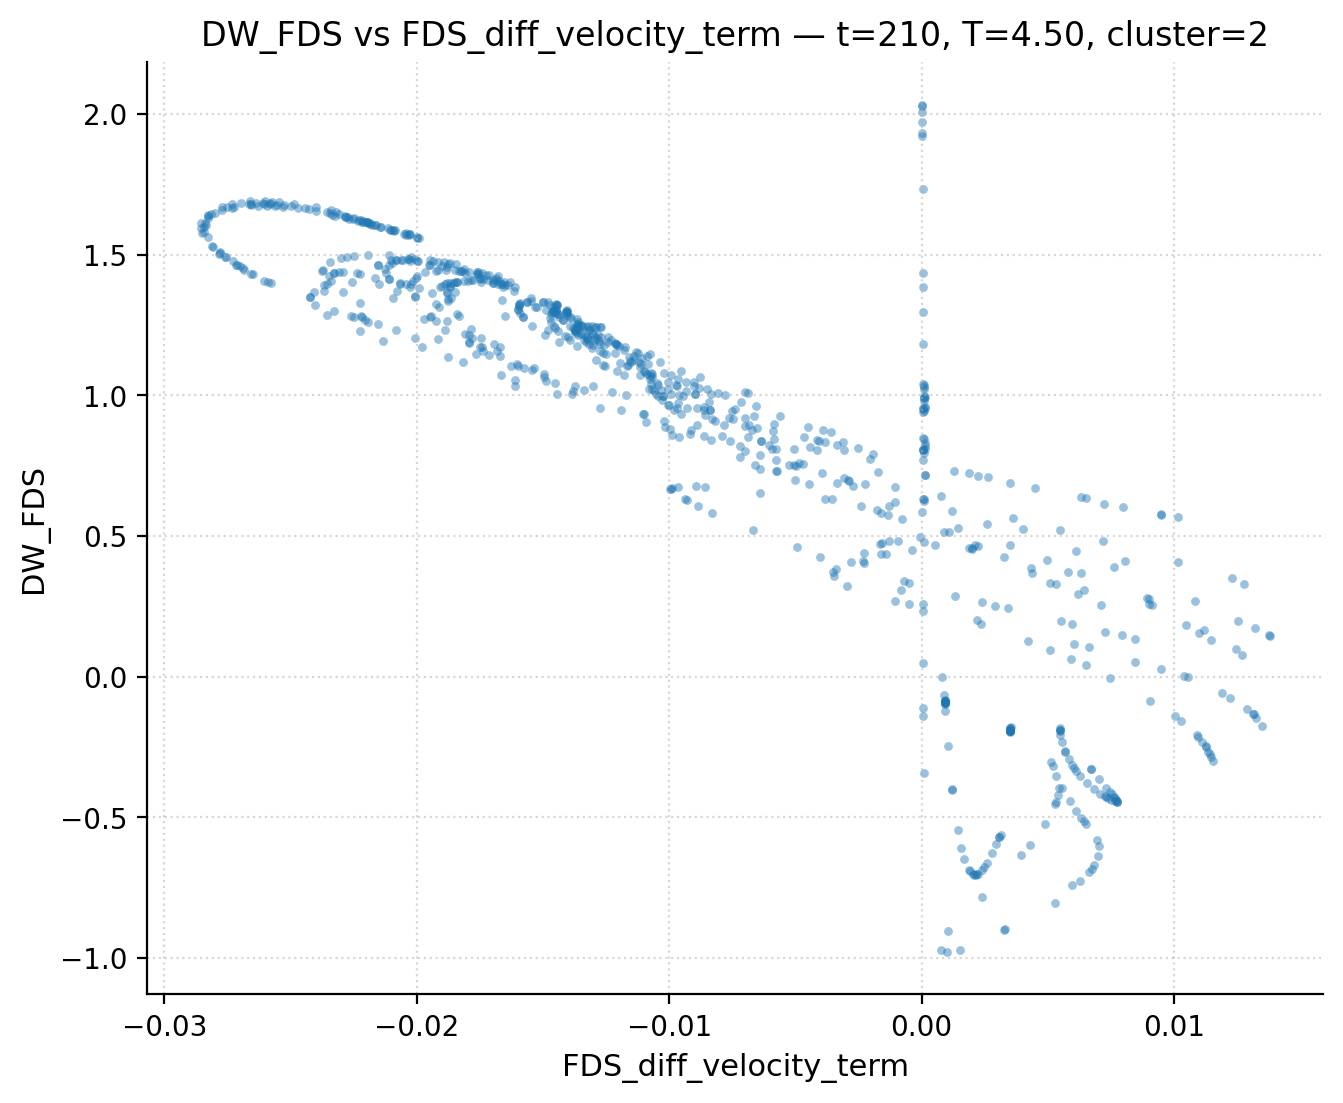

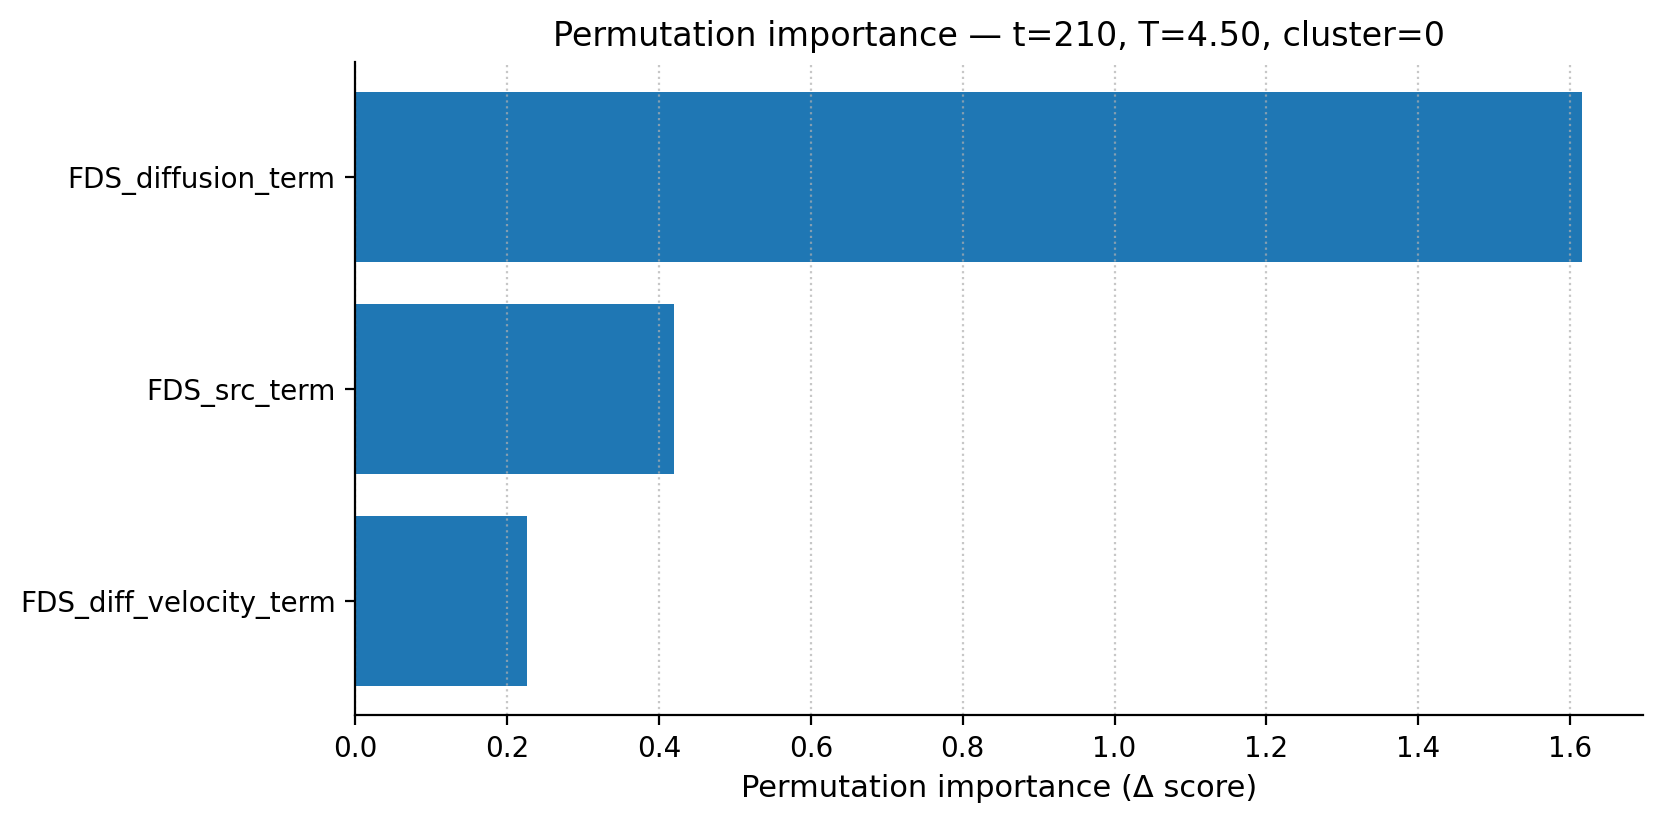

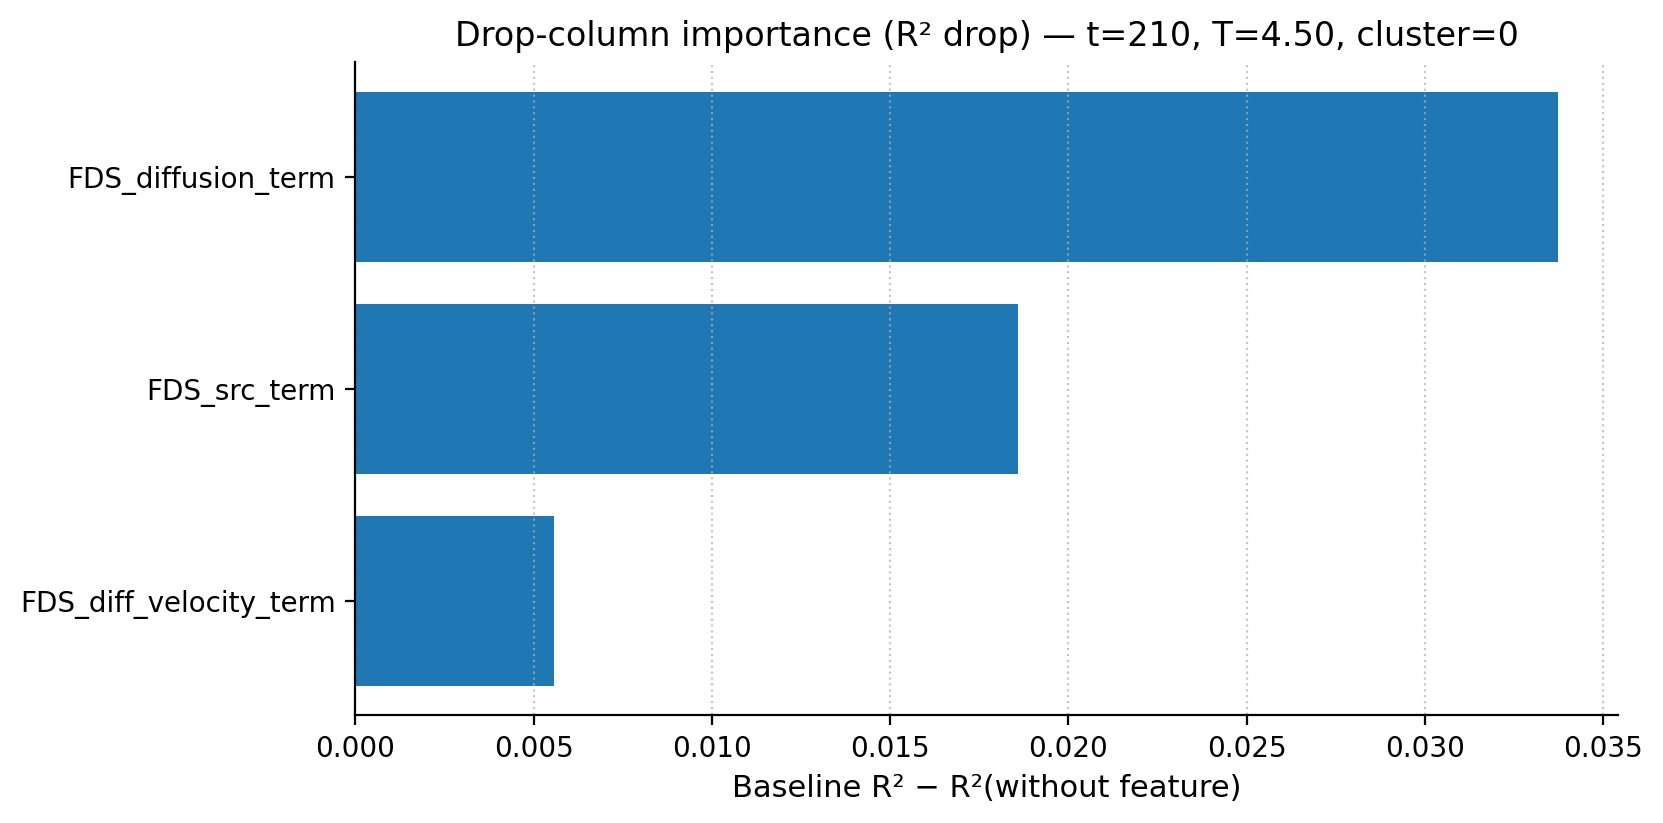

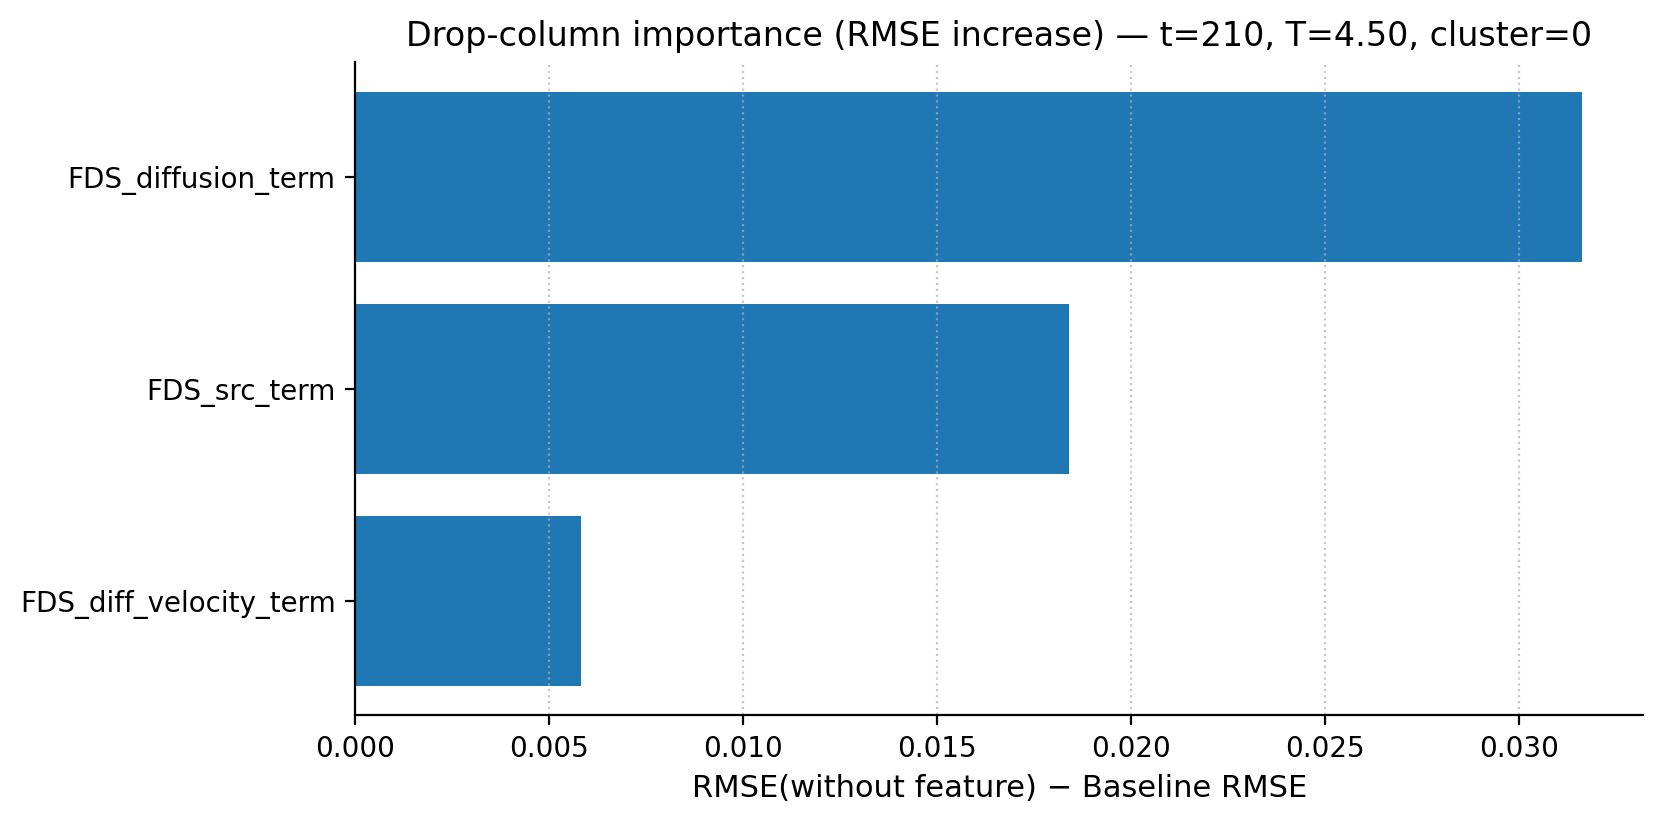


------------------------------------------------------------------------------------------
t=210 | T=4.50 | Cluster 0 | reg-valid n=906
Curvature thresholds: q1=-1.538556e-01, q2=1.883563e-01
Test R² = 0.9490 | Test RMSE = 1.094838e-01
Top feature (perm): FDS_diffusion_term
Top feature (dropcol R²): FDS_diffusion_term
Top feature (dropcol RMSE): FDS_diffusion_term


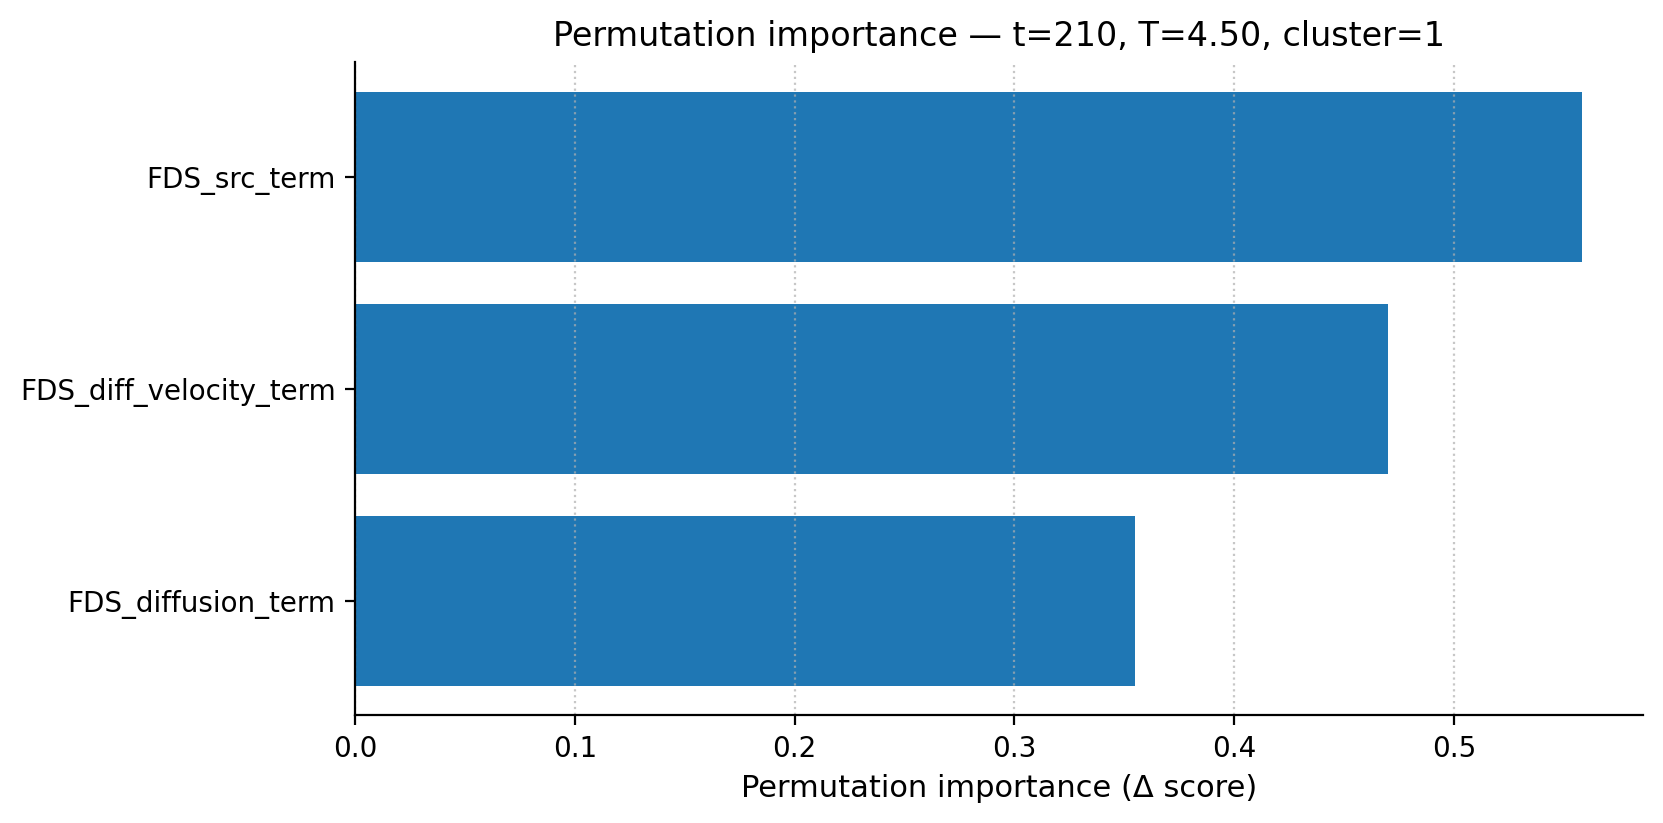

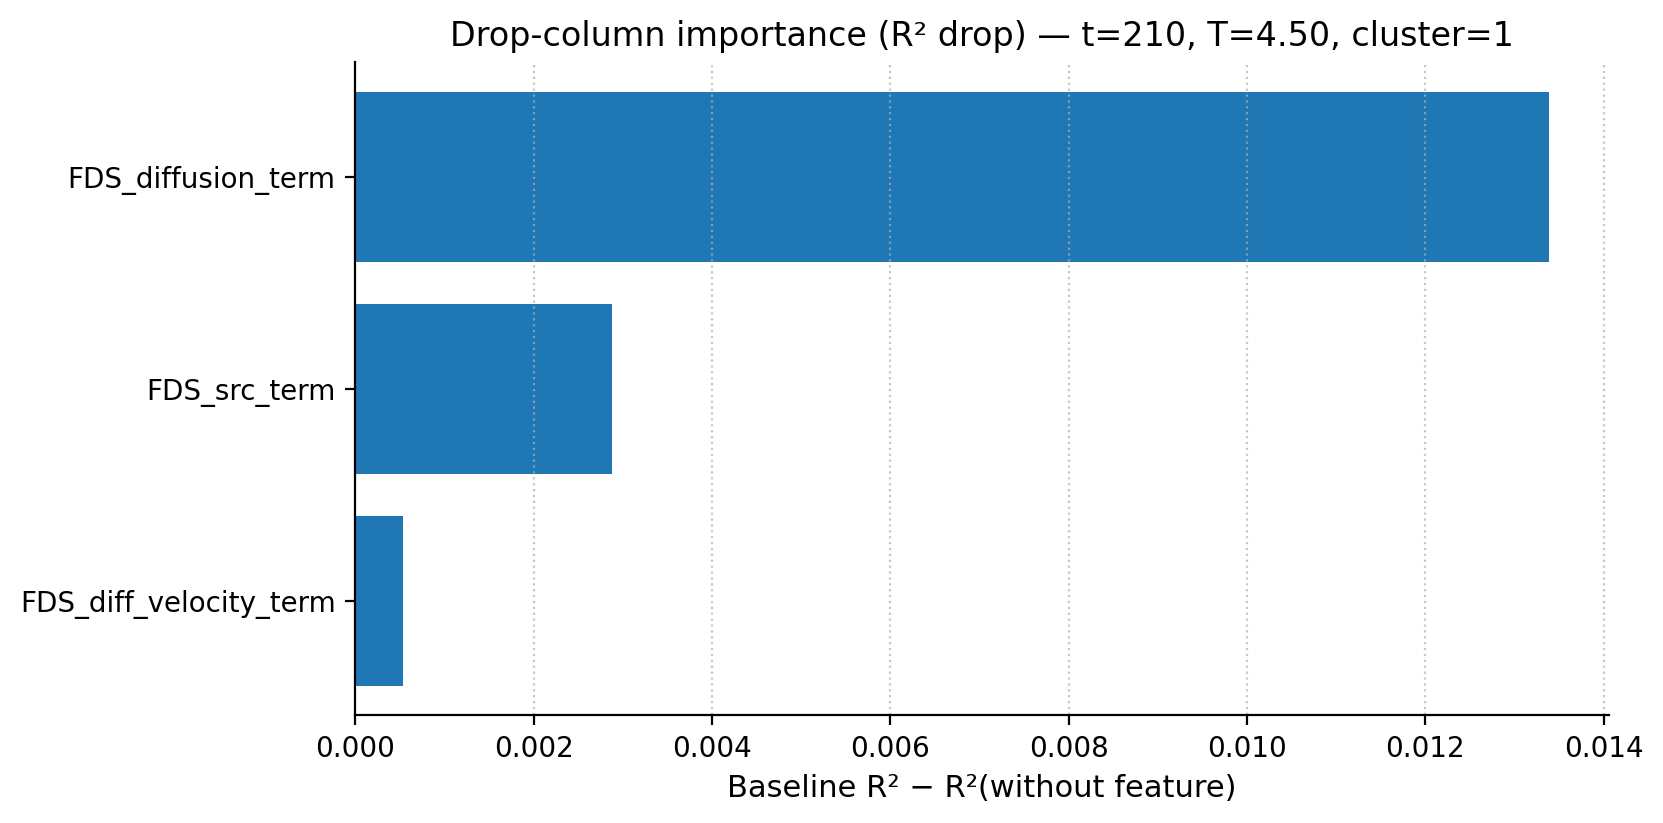

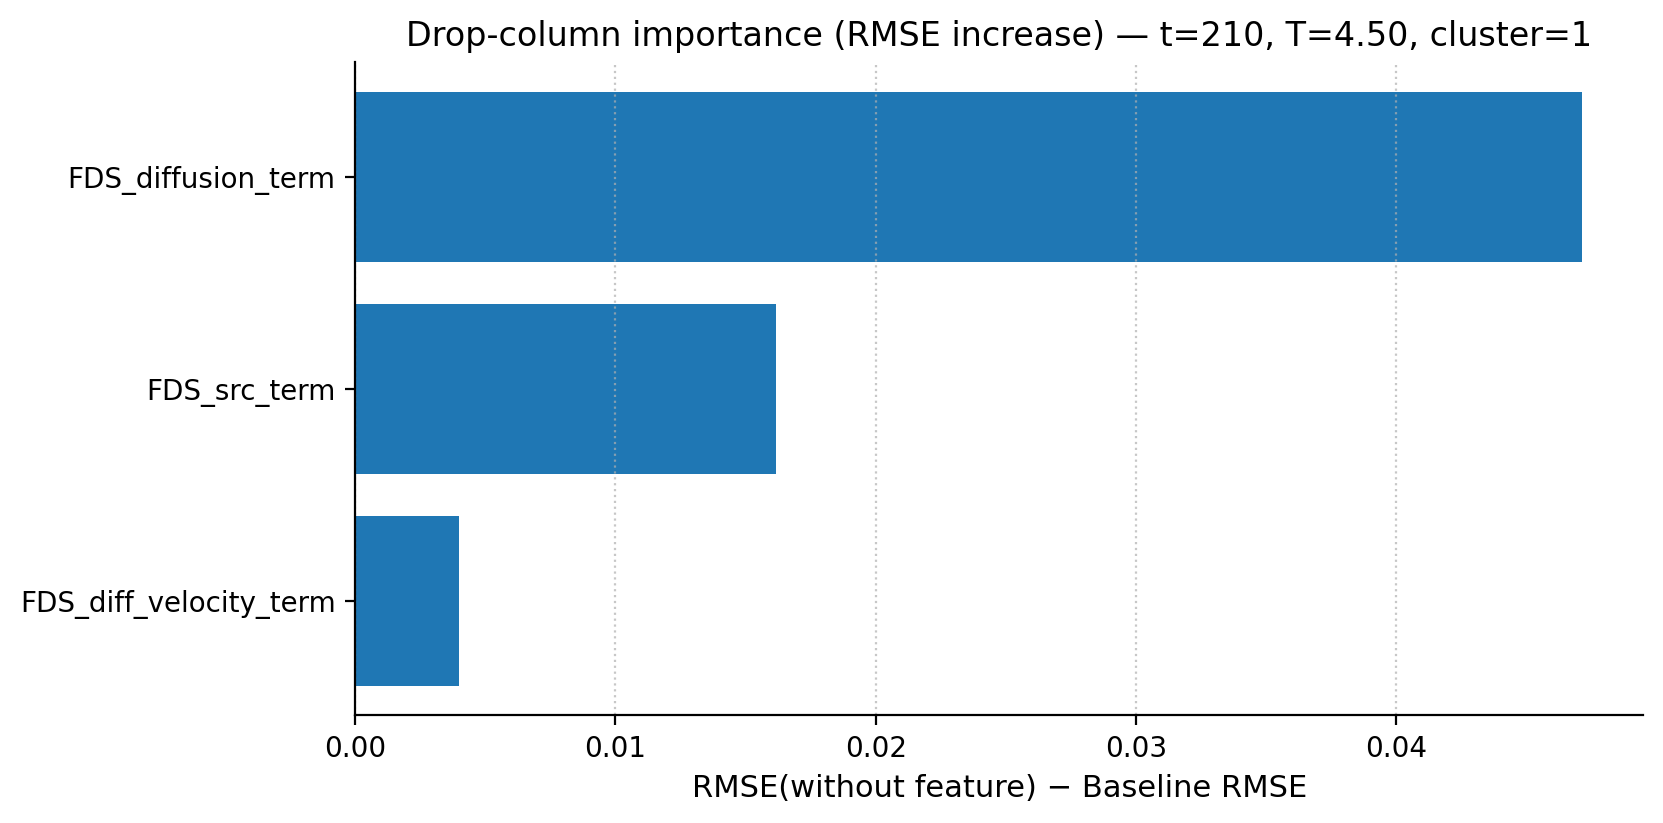


------------------------------------------------------------------------------------------
t=210 | T=4.50 | Cluster 1 | reg-valid n=7248
Curvature thresholds: q1=-1.538556e-01, q2=1.883563e-01
Test R² = 0.9989 | Test RMSE = 1.783307e-02
Top feature (perm): FDS_src_term
Top feature (dropcol R²): FDS_diffusion_term
Top feature (dropcol RMSE): FDS_diffusion_term


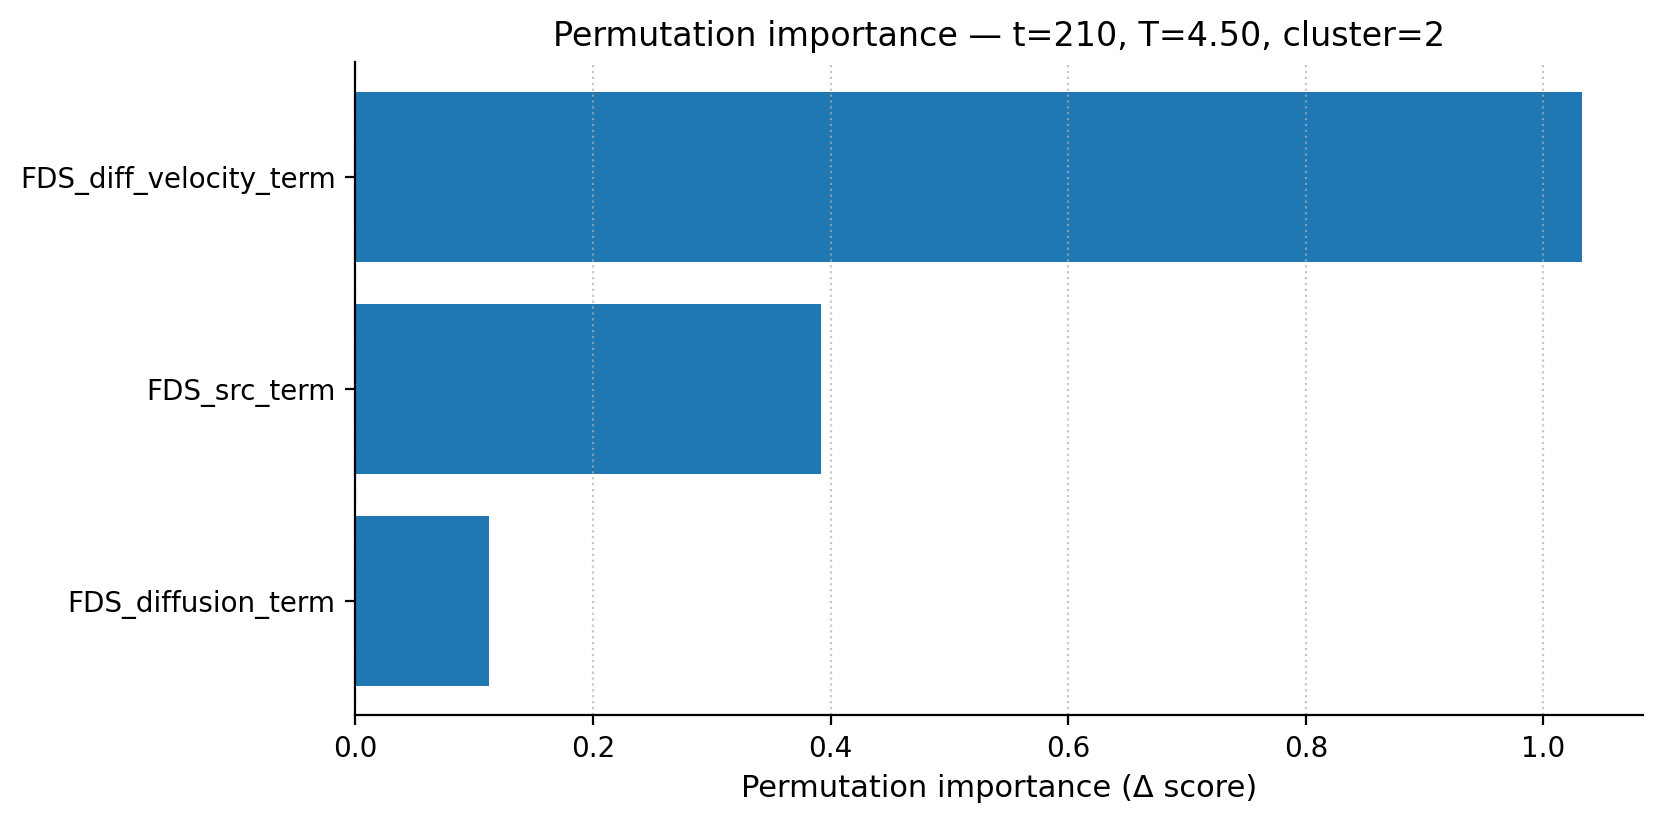

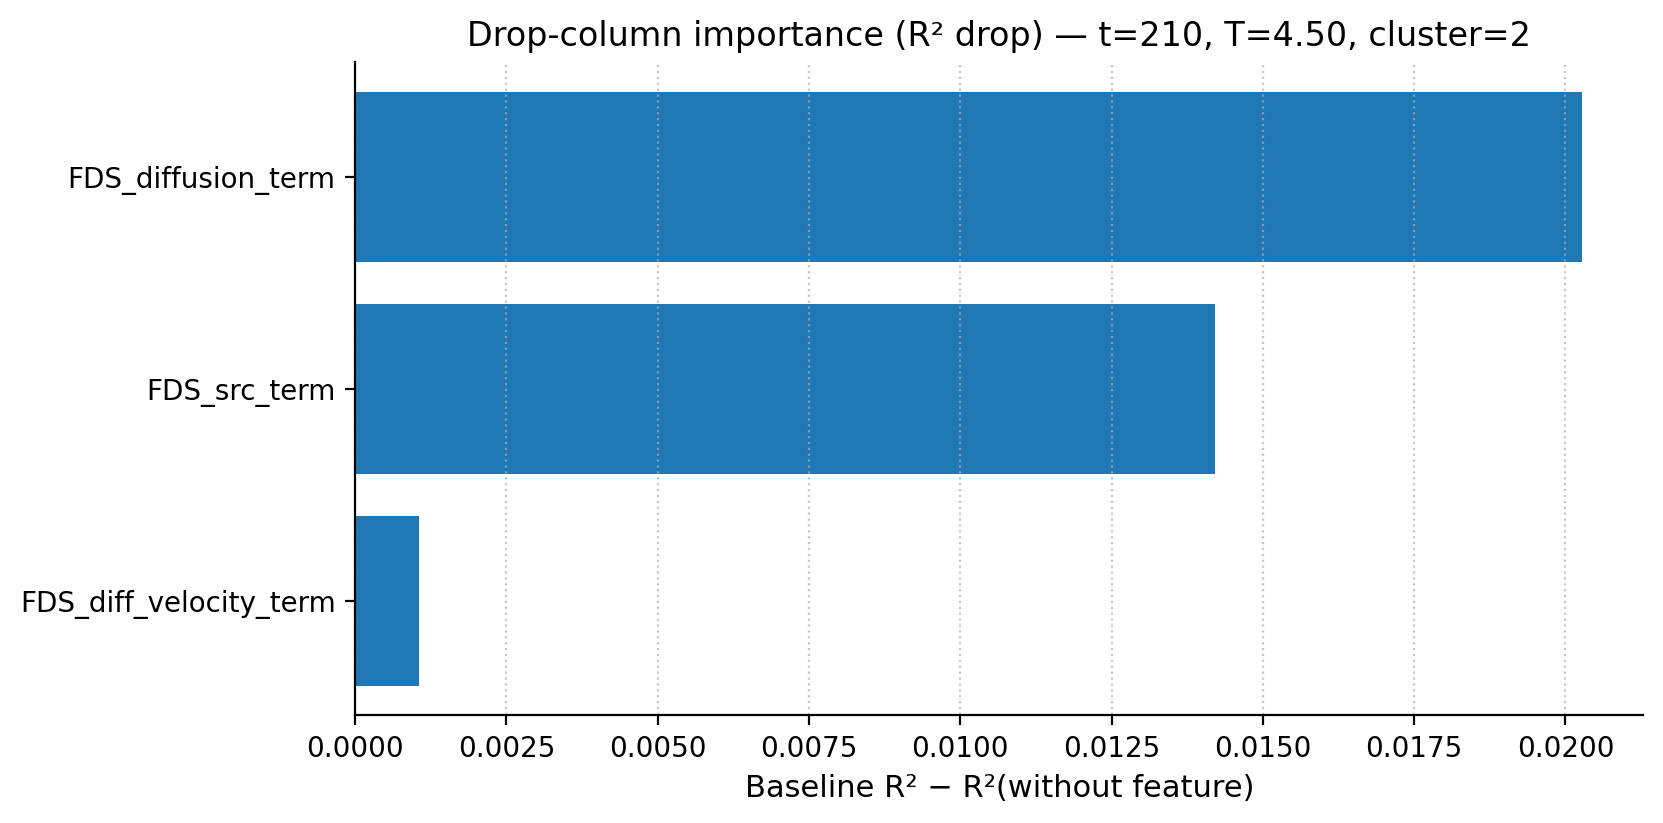

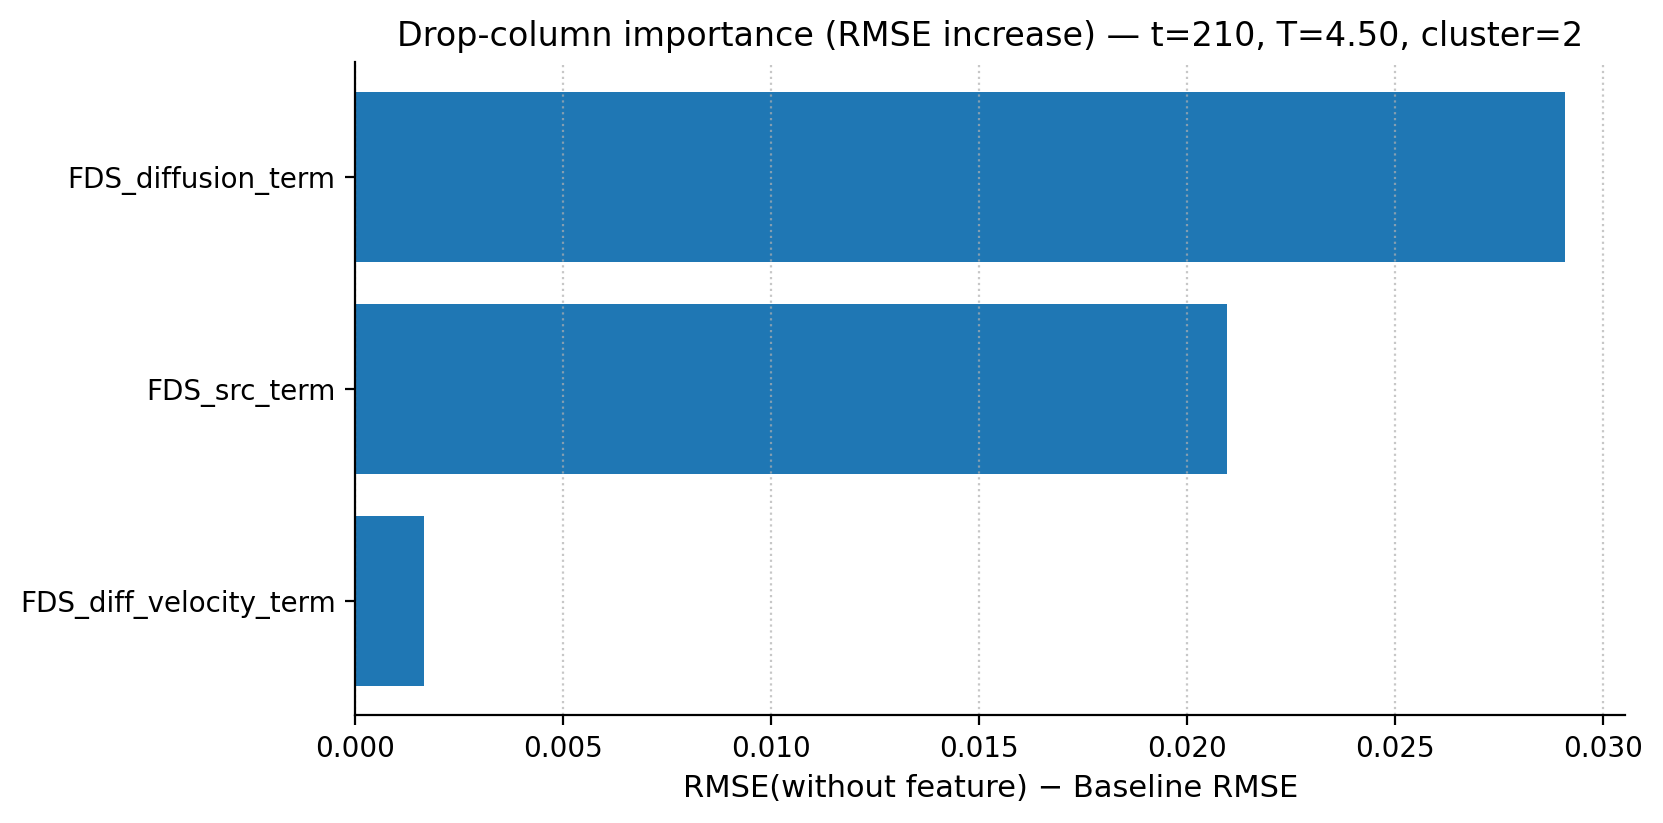


------------------------------------------------------------------------------------------
t=210 | T=4.50 | Cluster 2 | reg-valid n=906
Curvature thresholds: q1=-1.538556e-01, q2=1.883563e-01
Test R² = 0.9582 | Test RMSE = 1.328716e-01
Top feature (perm): FDS_diff_velocity_term
Top feature (dropcol R²): FDS_diffusion_term
Top feature (dropcol RMSE): FDS_diffusion_term

Summary (per time step, per isolevel, per cluster)
   time_step    T  cluster  n_cluster_reg_valid   r2_test  rmse_test        q1        q2                                       reg_features        top_feature_perm  perm_imp_mean__FDS_src_term  perm_imp_std__FDS_src_term  perm_imp_mean__FDS_diffusion_term  \
0        210  4.5        0                  906  0.948977   0.109484 -0.153856  0.188356  FDS_src_term,FDS_diffusion_term,FDS_diff_veloc...      FDS_diffusion_term                     0.420158                    0.031126                           1.615515   
1        210  4.5        1                 7248  0.998908 

In [11]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance

from flamekit.io_fronts import Case, load_fronts

# ============================================================
# USER SETTINGS
# ============================================================
PHI = 0.40
LAT_SIZE = "100"
ISOLEVELS = [4.5]

# ---- thresholds computed per timestep ----
TIME_STEPS = [210]

BASE_DIR = Path("../data/isocontours")
POST = True

# Optional Case fields (only used if your Case supports them)
MULTIPLE_RUNS = False
N_RUN = 2
SORET_TERM = False
SORET_POSITIVE = False

# ---- Curvature-based predetermined clusters ----
CURVATURE_COL = "curvature"
Q_LOW = 0.10
Q_HIGH = 0.90

# ------------------------------------------------------------
# Regression / importance settings
# ------------------------------------------------------------
REG_FEATURES = ["FDS_src_term", "FDS_diffusion_term", "FDS_diff_velocity_term"]
TARGET = "DW_FDS"

# --- Plot controls ---
POINT_SIZE = 10
MARKER = "s"
FIG_DPI = 200

# --- Data thresholds ---
MIN_VALID_SAMPLES_ISO = 200
MIN_SAMPLES_PER_CLUSTER_REG = 200
MIN_SAMPLES_PER_CLUSTER_CORR = 25
MIN_SAMPLES_PER_CLUSTER_CROSS = 50   # also used for DW_FDS-vs-feature plots
TEST_SIZE = 0.25
RANDOM_STATE = 0

# --- Regressor settings ---
RF_N_ESTIMATORS = 400
RF_MAX_DEPTH = None
RF_MIN_SAMPLES_LEAF = 5
RF_N_JOBS = -1

# --- Permutation importance ---
PERM_N_REPEATS = 15

# --- Drop-column importance ---
DO_DROP_COLUMN = True

# --- Cross plots ---
CROSS_COLOR_BY_TARGET = True  # cross feature-vs-feature colored by DW_FDS

# --- Figure saving ---
SAVE_FIGS = True
OUT_BASE_DIR = Path(r"C:\Users\alexp\Documents\Bachelor Thesis\report_figures\results\FDS_decomposition_analysis")

# Names remain constant in every folder:
XY_FNAME = "xy_plot.png"
PERM_FNAME_FMT = "cluster{cluster}_perm.png"
CORR_FNAME_FMT = "corr_matrix_cluster{cluster}.png"
DROP_R2_FNAME_FMT = "cluster{cluster}_dropcol_r2.png"
DROP_RMSE_FNAME_FMT = "cluster{cluster}_dropcol_rmse.png"
CROSS_FNAME_FMT = "cross_cluster{cluster}__{f1}__vs__{f2}.png"
DWVS_FNAME_FMT = "dw_vs_cluster{cluster}__DW_FDS__vs__{feat}.png"

# ============================================================
# MATPLOTLIB DEFAULTS (better quality)
# ============================================================
plt.rcParams.update({
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ============================================================
# HELPERS
# ============================================================
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN,
            soret_term=SORET_TERM,
            soret_positive=SORET_POSITIVE,
        )
    except TypeError:
        return Case(**base_kwargs)


def make_out_dir(lat_size: str, time_step: int, c_val: float) -> Path:
    return OUT_BASE_DIR / f"h_{lat_size}_t_{time_step}_T_{c_val:g}"


def require_columns(df: pd.DataFrame, cols: list[str], context: str = "") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{context} Missing columns: {missing}. Example available: {list(df.columns[:30])}")


def clean_valid_rows(df: pd.DataFrame, cols_needed: list[str]) -> pd.DataFrame:
    out = df[cols_needed].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return df.loc[out.index].copy()


def discrete_cluster_cmap(n_clusters: int):
    base = plt.get_cmap("tab10" if n_clusters <= 10 else "tab20")
    colors = [base(i) for i in range(n_clusters)]
    cmap = ListedColormap(colors, name=f"clusters_{n_clusters}")
    boundaries = np.arange(-0.5, n_clusters + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, cmap.N)
    return cmap, norm


def assign_curvature_clusters(curv: np.ndarray, q1: float, q2: float) -> np.ndarray:
    # 0: most negative, 1: mid, 2: most positive
    return np.digitize(curv, bins=[q1, q2], right=False).astype(int)


def plot_xy_clusters(front_xy: pd.DataFrame, c_val: float, time_step: int, n_clusters: int,
                     q1: float, q2: float, savepath: Path | None = None) -> None:
    cmap, norm = discrete_cluster_cmap(n_clusters)

    fig, ax = plt.subplots(figsize=(6.8, 6.2), dpi=FIG_DPI, constrained_layout=True)
    sc = ax.scatter(
        front_xy["x"], front_xy["y"],
        c=front_xy["cluster"],
        cmap=cmap, norm=norm,
        s=POINT_SIZE, marker=MARKER, linewidths=0,
        alpha=0.95, rasterized=True,
    )

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(
        f"Curvature-threshold clusters — T={float(c_val):.2f}, t={time_step}\n"
        f"q1={q1:.4e}, q2={q2:.4e}"
    )
    ax.set_aspect("equal", adjustable="box")

    cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("Cluster ID")
    cbar.set_ticks(np.arange(n_clusters))
    cbar.set_ticklabels(["0 (neg)", "1 (mid)", "2 (pos)"])

    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, dpi=FIG_DPI, bbox_inches="tight")

    plt.show()
    plt.close(fig)


def plot_importances(importances: pd.Series, title: str, xlabel: str, savepath: Path | None = None) -> None:
    imp = importances.sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(8.2, 4.0), dpi=FIG_DPI, constrained_layout=True)
    ax.barh(imp.index, imp.values)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, axis="x", linestyle=":", linewidth=0.8, alpha=0.7)

    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, dpi=FIG_DPI, bbox_inches="tight")

    plt.show()
    plt.close(fig)


def plot_corr_matrix(df: pd.DataFrame, features: list[str], title: str, savepath: Path | None = None) -> None:
    corr = df[features].corr(method="pearson").to_numpy()

    fig, ax = plt.subplots(figsize=(5.8, 4.9), dpi=FIG_DPI, constrained_layout=True)
    im = ax.imshow(corr, vmin=-1.0, vmax=1.0, cmap="coolwarm")

    ax.set_xticks(np.arange(len(features)))
    ax.set_yticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha="right")
    ax.set_yticklabels(features)
    ax.set_title(title)

    for i in range(len(features)):
        for j in range(len(features)):
            ax.text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center", fontsize=10)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
    cbar.set_label("Pearson correlation")

    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, dpi=FIG_DPI, bbox_inches="tight")

    plt.show()
    plt.close(fig)


def plot_cross_scatter_2d(
    df: pd.DataFrame,
    f1: str,
    f2: str,
    title: str,
    savepath: Path | None = None,
    color_by: str | None = None,
) -> None:
    fig, ax = plt.subplots(figsize=(6.6, 5.4), dpi=FIG_DPI, constrained_layout=True)

    if color_by is None:
        ax.scatter(df[f1], df[f2], s=10, alpha=0.35, linewidths=0, rasterized=True)
    else:
        sc = ax.scatter(df[f1], df[f2], c=df[color_by], s=10, alpha=0.6, linewidths=0, rasterized=True)
        cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label(color_by)

    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(title)
    ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.5)

    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, dpi=FIG_DPI, bbox_inches="tight")

    plt.show()
    plt.close(fig)


def plot_dw_vs_feature(
    df: pd.DataFrame,
    feat: str,
    time_step: int,
    c_val: float,
    cluster: int,
    savepath: Path | None = None,
) -> None:
    """
    Scatter plot: x = feature, y = DW_FDS.
    """
    fig, ax = plt.subplots(figsize=(6.6, 5.4), dpi=FIG_DPI, constrained_layout=True)

    ax.scatter(
        df[feat].to_numpy(),
        df[TARGET].to_numpy(),
        s=10,
        alpha=0.45,
        linewidths=0,
        rasterized=True,
    )

    ax.set_xlabel(feat)
    ax.set_ylabel(TARGET)
    ax.set_title(f"{TARGET} vs {feat} — t={time_step}, T={float(c_val):.2f}, cluster={cluster}")
    ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.5)

    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath, dpi=FIG_DPI, bbox_inches="tight")

    plt.show()
    plt.close(fig)


def compute_curvature_thresholds_for_timestep(fronts_t: dict[float, pd.DataFrame]) -> tuple[float, float, int]:
    curv_list = []
    for c_val, front in fronts_t.items():
        require_columns(front, [CURVATURE_COL], context=f"ISO {c_val}:")
        curv = (
            front[[CURVATURE_COL]]
            .replace([np.inf, -np.inf], np.nan)
            .dropna(axis=0, how="any")[CURVATURE_COL]
            .to_numpy()
        )
        if curv.size:
            curv_list.append(curv)

    if not curv_list:
        return np.nan, np.nan, 0

    curv_all = np.concatenate(curv_list, axis=0)
    q1 = float(np.nanquantile(curv_all, Q_LOW))
    q2 = float(np.nanquantile(curv_all, Q_HIGH))
    return q1, q2, int(curv_all.size)


def make_rf_model() -> RandomForestRegressor:
    return RandomForestRegressor(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF,
        n_jobs=RF_N_JOBS,
        random_state=RANDOM_STATE,
    )


def drop_column_importance(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    feature_names: list[str],
) -> tuple[pd.Series, pd.Series, float, float]:
    base_model = make_rf_model()
    base_model.fit(X_train, y_train)
    y_pred_base = base_model.predict(X_test)
    baseline_r2 = float(r2_score(y_test, y_pred_base))
    baseline_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_base)))

    drop_r2 = {}
    inc_rmse = {}

    for j, fname in enumerate(feature_names):
        Xtr = np.delete(X_train, j, axis=1)
        Xte = np.delete(X_test, j, axis=1)

        m = make_rf_model()
        m.fit(Xtr, y_train)
        y_pred = m.predict(Xte)

        r2_j = float(r2_score(y_test, y_pred))
        rmse_j = float(np.sqrt(mean_squared_error(y_test, y_pred)))

        drop_r2[fname] = baseline_r2 - r2_j
        inc_rmse[fname] = rmse_j - baseline_rmse

    return pd.Series(drop_r2), pd.Series(inc_rmse), baseline_r2, baseline_rmse


# ============================================================
# RUN
# ============================================================
clustered_fronts: dict[tuple[int, float], pd.DataFrame] = {}
summary_rows: list[dict] = []
N_CLUSTERS = 3

pairs = [
    (REG_FEATURES[0], REG_FEATURES[1]),
    (REG_FEATURES[0], REG_FEATURES[2]),
    (REG_FEATURES[1], REG_FEATURES[2]),
]

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, ISOLEVELS)

    q1, q2, ncurv = compute_curvature_thresholds_for_timestep(fronts_t)
    if ncurv == 0 or not np.isfinite(q1) or not np.isfinite(q2):
        print(f"t={t}: skipped (no valid curvature samples).")
        continue

    print(f"\nTime step {t}: curvature thresholds from n={ncurv} samples")
    print(f"  q1 (at {Q_LOW:.3f})  = {q1:.6e}")
    print(f"  q2 (at {Q_HIGH:.3f}) = {q2:.6e}")

    for c_val, front in fronts_t.items():
        front = front.copy()

        require_columns(front, ["x", "y", CURVATURE_COL], context=f"t={t}, ISO {c_val}:")
        require_columns(front, REG_FEATURES + [TARGET], context=f"t={t}, ISO {c_val}:")

        out_dir = make_out_dir(LAT_SIZE, t, float(c_val))
        if SAVE_FIGS:
            out_dir.mkdir(parents=True, exist_ok=True)

        # --- curvature clustering basis for labels + xy plot
        front_cluster = clean_valid_rows(front, ["x", "y", CURVATURE_COL])
        if len(front_cluster) < MIN_VALID_SAMPLES_ISO:
            print(f"t={t}, ISO {c_val}: skipped (cluster-valid n={len(front_cluster)} < {MIN_VALID_SAMPLES_ISO})")
            continue

        front_cluster["cluster"] = assign_curvature_clusters(front_cluster[CURVATURE_COL].to_numpy(), q1, q2)

        # Merge cluster labels back
        front["cluster"] = -1
        front.loc[front_cluster.index, "cluster"] = front_cluster["cluster"].values
        clustered_fronts[(t, float(c_val))] = front

        # XY plot
        xy_save = (out_dir / XY_FNAME) if SAVE_FIGS else None
        plot_xy_clusters(
            front_cluster[["x", "y", "cluster"]],
            c_val=float(c_val),
            time_step=t,
            n_clusters=N_CLUSTERS,
            q1=q1,
            q2=q2,
            savepath=xy_save,
        )

        # ====================================================
        # Per-cluster: correlation + feature cross-plots + DW_FDS vs feature
        # ====================================================
        for k in [0, 1, 2]:
            # correlation + cross plots (need REG_FEATURES, and TARGET only if coloring)
            cols_needed = REG_FEATURES + ([TARGET] if CROSS_COLOR_BY_TARGET else [])
            dfk = clean_valid_rows(front[front["cluster"] == k].copy(), cols_needed)

            if len(dfk) >= MIN_SAMPLES_PER_CLUSTER_CORR:
                # Correlation matrix
                corr_save = (out_dir / CORR_FNAME_FMT.format(cluster=int(k))) if SAVE_FIGS else None
                plot_corr_matrix(
                    dfk,
                    features=REG_FEATURES,
                    title=f"Feature correlations — t={t}, T={float(c_val):.2f}, cluster={k}",
                    savepath=corr_save,
                )

                # Feature-feature cross plots
                if len(dfk) >= MIN_SAMPLES_PER_CLUSTER_CROSS:
                    for f1, f2 in pairs:
                        cross_save = (out_dir / CROSS_FNAME_FMT.format(cluster=int(k), f1=f1, f2=f2)) if SAVE_FIGS else None
                        plot_cross_scatter_2d(
                            dfk,
                            f1=f1,
                            f2=f2,
                            title=f"{f1} vs {f2} — t={t}, T={float(c_val):.2f}, cluster={k}",
                            savepath=cross_save,
                            color_by=(TARGET if CROSS_COLOR_BY_TARGET else None),
                        )
                else:
                    print(f"t={t}, ISO {c_val} | Cluster {k}: cross plots skipped (n={len(dfk)} < {MIN_SAMPLES_PER_CLUSTER_CROSS}).")
            else:
                print(f"t={t}, ISO {c_val} | Cluster {k}: corr/cross skipped (n={len(dfk)} < {MIN_SAMPLES_PER_CLUSTER_CORR}).")

            # DW_FDS vs each feature (needs REG_FEATURES + TARGET)
            dfk_dw = clean_valid_rows(front[front["cluster"] == k].copy(), REG_FEATURES + [TARGET])
            if len(dfk_dw) < MIN_SAMPLES_PER_CLUSTER_CROSS:
                print(f"t={t}, ISO {c_val} | Cluster {k}: DW_FDS-vs-feature skipped (n={len(dfk_dw)} < {MIN_SAMPLES_PER_CLUSTER_CROSS}).")
            else:
                for feat in REG_FEATURES:
                    dw_save = (out_dir / DWVS_FNAME_FMT.format(cluster=int(k), feat=feat)) if SAVE_FIGS else None
                    plot_dw_vs_feature(
                        dfk_dw,
                        feat=feat,
                        time_step=t,
                        c_val=float(c_val),
                        cluster=int(k),
                        savepath=dw_save,
                    )

        # ====================================================
        # Per-cluster: regression + permutation + drop-column
        # ====================================================
        for k in [0, 1, 2]:
            dfk = clean_valid_rows(front[front["cluster"] == k].copy(), REG_FEATURES + [TARGET])
            n_k = len(dfk)

            if n_k < MIN_SAMPLES_PER_CLUSTER_REG:
                print(f"t={t}, ISO {c_val} | Cluster {k}: skipped (reg-valid n={n_k} < {MIN_SAMPLES_PER_CLUSTER_REG})")
                continue

            X = dfk[REG_FEATURES].to_numpy()
            y = dfk[TARGET].to_numpy()

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
            )

            model = make_rf_model()
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            r2 = float(r2_score(y_test, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

            # Permutation importance
            perm = permutation_importance(
                model, X_test, y_test,
                n_repeats=PERM_N_REPEATS,
                random_state=RANDOM_STATE,
                n_jobs=RF_N_JOBS,
            )
            perm_mean = pd.Series(perm.importances_mean, index=REG_FEATURES)
            perm_std = pd.Series(perm.importances_std, index=REG_FEATURES)

            perm_save = (out_dir / PERM_FNAME_FMT.format(cluster=int(k))) if SAVE_FIGS else None
            plot_importances(
                perm_mean,
                title=f"Permutation importance — t={t}, T={float(c_val):.2f}, cluster={k}",
                xlabel="Permutation importance (Δ score)",
                savepath=perm_save,
            )

            # Drop-column importance
            drop_r2 = None
            inc_rmse = None
            base_r2_dc = None
            base_rmse_dc = None

            if DO_DROP_COLUMN:
                drop_r2, inc_rmse, base_r2_dc, base_rmse_dc = drop_column_importance(
                    X_train, y_train, X_test, y_test, REG_FEATURES
                )

                drop_r2_save = (out_dir / DROP_R2_FNAME_FMT.format(cluster=int(k))) if SAVE_FIGS else None
                plot_importances(
                    drop_r2,
                    title=f"Drop-column importance (R² drop) — t={t}, T={float(c_val):.2f}, cluster={k}",
                    xlabel="Baseline R² − R²(without feature)",
                    savepath=drop_r2_save,
                )

                drop_rmse_save = (out_dir / DROP_RMSE_FNAME_FMT.format(cluster=int(k))) if SAVE_FIGS else None
                plot_importances(
                    inc_rmse,
                    title=f"Drop-column importance (RMSE increase) — t={t}, T={float(c_val):.2f}, cluster={k}",
                    xlabel="RMSE(without feature) − Baseline RMSE",
                    savepath=drop_rmse_save,
                )

            # Summary row
            row = {
                "time_step": int(t),
                "T": float(c_val),
                "cluster": int(k),
                "n_cluster_reg_valid": int(n_k),
                "r2_test": r2,
                "rmse_test": rmse,
                "q1": q1,
                "q2": q2,
                "reg_features": ",".join(REG_FEATURES),
                "top_feature_perm": perm_mean.idxmax(),
            }
            for f in REG_FEATURES:
                row[f"perm_imp_mean__{f}"] = float(perm_mean[f])
                row[f"perm_imp_std__{f}"] = float(perm_std[f])

            if DO_DROP_COLUMN and drop_r2 is not None and inc_rmse is not None:
                row["baseline_r2_dropcol"] = float(base_r2_dc)
                row["baseline_rmse_dropcol"] = float(base_rmse_dc)
                row["top_feature_dropcol_r2"] = drop_r2.idxmax()
                row["top_feature_dropcol_rmse"] = inc_rmse.idxmax()
                for f in REG_FEATURES:
                    row[f"dropcol_r2_drop__{f}"] = float(drop_r2[f])
                    row[f"dropcol_rmse_inc__{f}"] = float(inc_rmse[f])

            summary_rows.append(row)

            print("\n" + "-" * 90)
            print(f"t={t} | T={float(c_val):.2f} | Cluster {k} | reg-valid n={n_k}")
            print(f"Curvature thresholds: q1={q1:.6e}, q2={q2:.6e}")
            print(f"Test R² = {r2:.4f} | Test RMSE = {rmse:.6e}")
            print(f"Top feature (perm): {perm_mean.idxmax()}")
            if DO_DROP_COLUMN and drop_r2 is not None:
                print(f"Top feature (dropcol R²): {drop_r2.idxmax()}")
                print(f"Top feature (dropcol RMSE): {inc_rmse.idxmax()}")

# ============================================================
# SUMMARY TABLE
# ============================================================
if summary_rows:
    summary = pd.DataFrame(summary_rows).sort_values(["time_step", "T", "cluster"]).reset_index(drop=True)
    print("\n" + "=" * 90)
    print("Summary (per time step, per isolevel, per cluster)")
    print("=" * 90)
    with pd.option_context("display.max_columns", 500, "display.width", 260):
        print(summary)

    if SAVE_FIGS:
        csv_path = OUT_BASE_DIR / "dropcol_perm_summary.csv"
        summary.to_csv(csv_path, index=False)
        print(f"\nSaved summary CSV: {csv_path}")
else:
    print("No cluster models were trained (insufficient valid samples or clusters too small).")
